# Introduction
17/9/2020

This workbook details a workflow on GoM (Gulf of Mexico) onshore and offshore count data to examine the major fossils groups that characterise the late Paleocene (Selandian-Thanetian 60-55 Ma) and the early Eocene (Ypresian 55-53 Ma) using PCA, random forest classifier modeling and VIF scores. Data were cleaned in previous steps and the count data were transformed by Hellinger transformation so that PCA could be used. 

__The aim is to separate different regions and find the taxa that are most significant.__

In [1]:
import pandas as pd
import numpy as np

#Plotting libraries and other types
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib import gridspec
from collections import Counter
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd


#Analytical libraries
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#Import statsmodel for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Import PCA libraries
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Mute warning messages: If errors occur, hash-out this import
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

## Functions

In [2]:
def subset(df, name, col_name):
    name = df.loc[(df[col_name] == name)]
    #Checks that the samples are in the correct order for the well.
    name = name.sort_values(by=['BASE'], ascending=False)
    return name

# df is the df name of interest
# Name is the identify label of interest within the given column (col_name)

In [3]:
## Fonts for plotting

a_font = {'fontname':'Arial'}#use to change font
itals = {'fontstyle':'italic'}

## plt.rcdefaults() #returns to plt defaults

## Load cleaned Onshore GoM Selandian-Thanetian samples



In [4]:
sel_than = pd.read_csv('sel_than_onshore.csv').drop('Unnamed: 0',axis=1)
sel_than.head()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Rhoipites capax-latus,Rhoipites cryptoporus,Spinaepollis spinosus,Tetracolporates grp.,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.
0,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.056433,0.138233,0.195491,0.0,0.159617,0.356915,0.000000,0.097745,0.0,0.056433
1,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.000000,0.130466,0.065233,0.0,0.112987,0.380369,0.112987,0.000000,0.0,0.065233
2,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.091670,0.158777,0.112272,0.0,0.158777,0.366679,0.091670,0.064820,0.0,0.000000
3,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.000000,0.172958,0.065372,0.0,0.269536,0.345916,0.092450,0.065372,0.0,0.000000
4,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.000000,0.202548,0.124035,0.0,0.258199,0.464095,0.000000,0.071611,0.0,0.143223


In [5]:
## Drop redundnant columns or caved samples
# list(sel_than.columns)

sel_than.drop(['Annona foveoreticulata.',
               'Brosipollis spp.',
               'Engelhardtioidites spp.',
               'Intratriporopollenites instructus',
               'Intratriporopollenites cf instructus',
               'Juglanspollenites grp.',
               'Lanagiopollis (Eocene) grp.',
               'Platycaryapollenites spp.',
               'Quercoidites',
               'Retistephanocolporites',
               'Rhoipites capax-latus'], axis=1, inplace=True)

# ONSHORE Random forest

In [6]:
sel_than.columns

Index(['P_REGION', 'AREA', 'LAT', 'LONG', 'AGE', 'STAGE', 'GRP', 'ZONE',
       'SUBZONE', 'TOP', 'BASE', 'TYPE', 'ANALYST', 'REGION', 'LABEL', 'SITE',
       'N', 'S', 'R100', 'St dev', 'E1/D', 'Freshwater algae',
       'Alnipollenites verus', 'Baculatisporites/Osmunda grp.',
       'Bagelopollis verrucatus', 'Bisaccates', 'Bombacacidites spp.',
       'Caprifoliipites viridifluminis', 'Caryapollenites spp.',
       'Celtispollenites spp.', 'Chenopodipollenites grp.',
       'Cicatricosisporites grp.', 'Deltoidospora spp.', 'Ephedra spp.',
       'Favitricolporites baculoferus', 'Holkopollenites spp.',
       'Ilexpollenites grp.', 'Inaperturopollenites spp.',
       'Kyandopollenites anneratus', 'Labrapollis globosus',
       'Laevigatosporites spp.', 'Lanagiopollis (Paleocene)', 'Milfordia spp.',
       'Momipites actinus grp.', 'Momipites grp.', 'Palms grp.',
       'Pistillipollenites mcgregorii', 'Polypodium type',
       'Proxapertites magnus', 'Retitrescolputes anguloluminosus

In [7]:
X = sel_than.loc[:,'Freshwater algae':]
Y = sel_than.loc[:,'REGION']

X_train, x_test, Y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=45, stratify=Y)

'''
Note: since these represent count data where each column is a different taxonomic group or fossil species 
and each row is a different sample, data can be scaled before splitting because there will be no information leakage between samples.
Hellinger transformation (see worksheet in this repo) works on a sample per sample basis.
'''

'\nNote: since these represent count data where each column is a different taxonomic group or fossil species \nand each row is a different sample, data can be scaled before splitting because there will be no information leakage between samples.\nHellinger transformation (see worksheet in this repo) works on a sample per sample basis.\n'

In [8]:
print('Y_train labels:\n\n{}'.format(Y_train.value_counts().sort_index()))
print('\ny_test labels:\n\n{}'.format(y_test.value_counts().sort_index()))

Y_train labels:

AL       51
C-TX     30
E-TX     33
HSTN    157
LA       62
MS       56
W-TX     30
Name: REGION, dtype: int64

y_test labels:

AL      13
C-TX     7
E-TX     8
HSTN    39
LA      16
MS      14
W-TX     8
Name: REGION, dtype: int64


In [15]:
'''
Randomly oversample the data in case this improves the training of the models. We don't have that much data to play with!
'''

## Using synthetic over-sampling by K-means distance. Worth a shot.
from imblearn.over_sampling import SMOTE

# sample_sizes = {'AL':20, #change these manually if necessary and pass sample_sizes as the sampling_strategy
#                 'C-TX':20,
#                'E-TX': 20,
#                'HSTN':56,
#                'LA':58,
#                'MS':36,
#                'W-TX': 28}

smote = SMOTE(sampling_strategy='not majority',k_neighbors=3, random_state=45) #resamples all except largest class.
X_sm, y_sm = smote.fit_sample(X_train, Y_train)

from collections import Counter
print('\nOriginal data: \n',sorted(Counter(Y_train).items()))
print('SMOTE data: \n', sorted(Counter(y_sm).items()))


Original data: 
 [('AL', 51), ('C-TX', 30), ('E-TX', 33), ('HSTN', 157), ('LA', 62), ('MS', 56), ('W-TX', 30)]
SMOTE data: 
 [('AL', 157), ('C-TX', 157), ('E-TX', 157), ('HSTN', 157), ('LA', 157), ('MS', 157), ('W-TX', 157)]


In [16]:
## Edit the region names to something more intuitive
replace_labels = {'AL':'Alabama',
              'C-TX':'Central TX',
              'E-TX':'East TX',
              'HSTN':'HSTN embayment',
              'LA':'Louisiana',
              'MS':'Mississippi',
              'W-TX':'West TX'}

Y_train.replace(replace_labels, inplace=True)

##Generate a list of labels for the heatmaps (these are sorted alphabetically, so sort them here)
new_labels = sorted(Y_train.unique()) #sort the unique labels for regions. .sort doesn't work on a np array
print(new_labels)

['Alabama', 'Central TX', 'East TX', 'HSTN embayment', 'Louisiana', 'Mississippi', 'West TX']


In [17]:
'''
Tune the Random forest classifier.

Use f1 weighting because of class imbalance.
'''

##Tune parameters for Random Forest Classifier
param_grid = {'n_estimators':[100, 150, 200, 250, 300], #Last iteration of grid.
             'max_depth': [30, 40, 50, 60, 70]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=4, scoring='f1_weighted')
grid.fit(X_sm,y_sm)

print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross-validation score: 0.99
Best parameters:  {'n_estimators': 150, 'max_depth': 40}


In [18]:
rfc = RandomForestClassifier(n_estimators=150, 
                             max_depth=40, 
                             random_state=45, 
                             class_weight='balanced_subsample')
rfc.fit(X_sm, y_sm)
y_pred = rfc.predict(x_test)

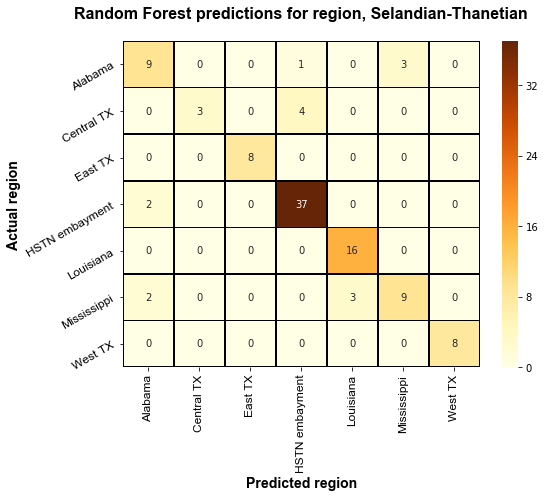

In [19]:
conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8,6))

plt.subplot(111)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.75, linecolor='black',
                 cmap='YlOrBr',
                xticklabels=new_labels,
                yticklabels=new_labels)
ax.set_ylabel('Actual region', fontsize=14, weight='bold', **a_font)
ax.set_xlabel('Predicted region', fontsize=14, weight='bold', **a_font)
ax.set_title('Random Forest predictions for region, Selandian-Thanetian', fontsize=16, weight='bold', y=1.05, **a_font)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, **a_font)
ax.set_yticklabels(ax.get_yticklabels(),rotation=30, **a_font)
ax.tick_params(labelsize=12) #changes the label size for tick marks

plt.show()
# plt.savefig('RFC_Selandian_Thanetian_confusion_matrix.png',dpi=150,bbox_inches='tight', transparent=True)

In [21]:
print('\n\nClassification report for RFC of data:\n')
print(classification_report(y_test, y_pred, target_names=new_labels))



Classification report for RFC of data:

                precision    recall  f1-score   support

       Alabama       0.69      0.69      0.69        13
    Central TX       1.00      0.43      0.60         7
       East TX       1.00      1.00      1.00         8
HSTN embayment       0.88      0.95      0.91        39
     Louisiana       0.84      1.00      0.91        16
   Mississippi       0.75      0.64      0.69        14
       West TX       1.00      1.00      1.00         8

     micro avg       0.86      0.86      0.86       105
     macro avg       0.88      0.82      0.83       105
  weighted avg       0.86      0.86      0.85       105



## Selandian-Thanetian: Feature importance

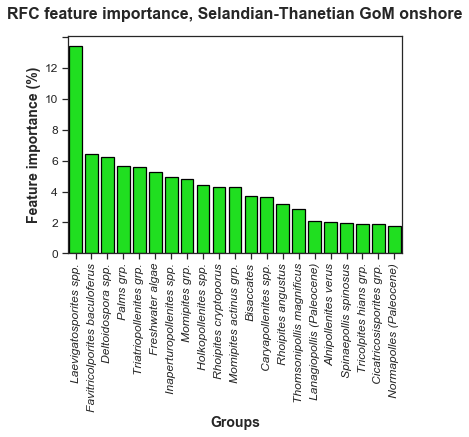

In [22]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.barplot(feature_importances.index[:21], feature_importances['importance'][:21],
                 alpha=1,color="#00ff00", linewidth=1)
plt.setp(ax.patches, linewidth=1.25, edgecolor='black') #Makes lines around bars black and thicker
ax.set_title('RFC feature importance, Selandian-Thanetian GoM onshore', fontsize=16, weight='bold',y=1.05,**a_font)
ax.set_ylabel('Feature importance (%)', fontsize=14, weight='bold', **a_font)
ax.set_xlabel('Groups', fontsize=14, weight='bold', **a_font)
ax.tick_params(labelsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, **itals, **a_font)
ax.set_yticklabels(np.arange(0,14,2), **a_font)

plt.show()
# plt.savefig('RFC_Selandian_Thanetian_feature_importance.png',dpi=150,bbox_inches='tight', transparent=True)

In [23]:
## Feature importances for top 20 groups
print(feature_importances[:21])

                               importance
Laevigatosporites spp.           0.133789
Favitricolporites baculoferus    0.064119
Deltoidospora spp.               0.062147
Palms grp.                       0.056297
Triatriopollenites grp.          0.055782
Freshwater algae                 0.052770
Inaperturopollenites spp.        0.049194
Momipites grp.                   0.048294
Holkopollenites spp.             0.044403
Rhoipites cryptoporus            0.043050
Momipites actinus grp.           0.042987
Bisaccates                       0.037327
Caryapollenites spp.             0.036551
Rhoipites angustus               0.031983
Thomsonipollis magnificus        0.028621
Lanagiopollis (Paleocene)        0.020664
Alnipollenites verus             0.020511
Spinaepollis spinosus            0.019770
Tricolpites hians grp.           0.019178
Cicatricosisporites grp.         0.018779
Normapolles (Paleocene)          0.017460


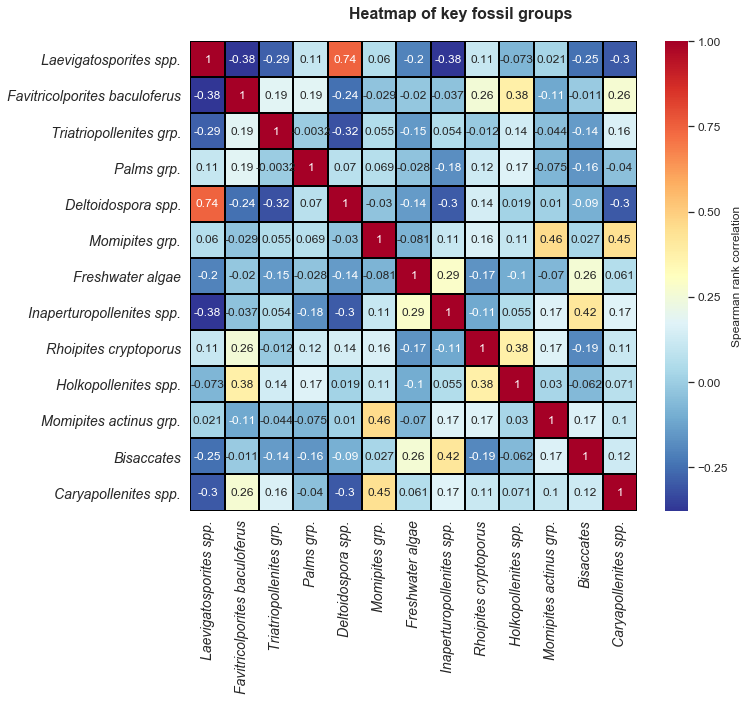

In [24]:
## Create a heatmap to see if these features are collinear
terr_heatmap = sel_than[['Laevigatosporites spp.',
                                'Favitricolporites baculoferus',
                                'Triatriopollenites grp.',
                                'Palms grp.',
                                'Deltoidospora spp.',
                                'Momipites grp.',
                                'Freshwater algae',
                                'Inaperturopollenites spp.',
                                'Rhoipites cryptoporus',
                                'Holkopollenites spp.',
                                'Momipites actinus grp.',
                                'Bisaccates',
                                'Caryapollenites spp.']]

sns.set(font = 'arial')
plt.subplots(figsize=(10,8))
ax=plt.subplot(111)
sns.heatmap(terr_heatmap.corr(method='spearman'), annot=True, cmap='RdYlBu_r', linewidth=1,linecolor='black',
           cbar_kws={'label': 'Spearman rank correlation'})
plt.tick_params(labelsize=12)
plt.suptitle('Heatmap of key fossil groups', weight='bold', fontsize=16, y=1, **a_font)
plt.subplots_adjust(top=0.94)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, **itals, **a_font)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, **itals, **a_font)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

plt.show()
# plt.savefig('Heatmap_Selandian_Thanetian_important_groups.png',dpi=150,bbox_inches='tight', transparent=True)

### VIF scores

This code will get the VIF value for all features and then place them in a dataframe sorted by value so they can be plotted.
Note that just calling X direct doesn't work and will raise a hashable slice error. A loop is needed to go through each 
feature. Code from https://etav.github.io/python/vif_factor_python.html for a df of VIF scores

In [34]:
'''
EXAMPLE CODE:

df_vif = pd.DataFrame()
df_vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
df_vif["Features"] = X.columns

#Sort values
df_vif = df_vif.sort_values(by='VIF Factor', ascending=0)
'''

'\ndf_vif = pd.DataFrame()\ndf_vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]\ndf_vif["Features"] = X.columns\n\n#Sort values\ndf_vif = df_vif.sort_values(by=\'VIF Factor\', ascending=0)\n'

In [25]:
Y_vif = sel_than.loc[:,'REGION']
X_vif = sel_than.loc[:,'Freshwater algae':]

X_vif.head()

,Freshwater algae,Alnipollenites verus,Baculatisporites/Osmunda grp.,Bagelopollis verrucatus,Bisaccates,Bombacacidites spp.,Caprifoliipites viridifluminis,Caryapollenites spp.,Celtispollenites spp.,Chenopodipollenites grp.,...,Rhoipites angustus,Rhoipites cryptoporus,Spinaepollis spinosus,Tetracolporates grp.,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.
0,0.079809,0.056433,0.0,0.0,0.112867,0.000000,0.0,0.314207,0.0,0.056433,...,0.000000,0.138233,0.195491,0.0,0.159617,0.356915,0.000000,0.097745,0.0,0.056433
1,0.184506,0.065233,0.0,0.0,0.235200,0.000000,0.0,0.396796,0.0,0.000000,...,0.130466,0.130466,0.065233,0.0,0.112987,0.380369,0.112987,0.000000,0.0,0.065233
2,0.242536,0.112272,0.0,0.0,0.204980,0.000000,0.0,0.444386,0.0,0.000000,...,0.091670,0.158777,0.112272,0.0,0.158777,0.366679,0.091670,0.064820,0.0,0.000000
3,0.092450,0.113228,0.0,0.0,0.206725,0.000000,0.0,0.369800,0.0,0.065372,...,0.092450,0.172958,0.065372,0.0,0.269536,0.345916,0.092450,0.065372,0.0,0.000000
4,0.143223,0.124035,0.0,0.0,0.226455,0.071611,0.0,0.189466,0.0,0.000000,...,0.160128,0.202548,0.124035,0.0,0.258199,0.464095,0.000000,0.071611,0.0,0.143223


In [26]:
'''
VIF scores
'''

vif_sel_than = pd.DataFrame()
vif_sel_than["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_sel_than["Features"] = X_vif.columns

#Sort values
vif_sel_than = vif_sel_than.sort_values(by='VIF Factor', ascending=0)

In [27]:
# vif_sel_than.max() #What is the maximum value?
# vif_sel_than[vif_sel_than['VIF Factor'] >5].count() #How many are above the threshold?
vif_sel_than.head()

,VIF Factor,Features
23,9.915220,Momipites grp.
11,9.401905,Deltoidospora spp.
19,7.852457,Laevigatosporites spp.
33,7.111648,Thomsonipollis magnificus
34,6.665838,Triatriopollenites grp.


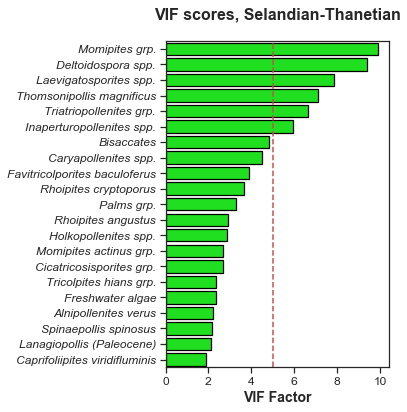

In [28]:
'''
Plot VIF factors to establish degree of multicollinearity. These are count data so will represent communities and so will have interdependence.
'''

sns.set(style="ticks", font='Arial')

fig, ax = plt.subplots(figsize=(4,6))
ax = sns.barplot(y=vif_sel_than['Features'][:21], x=vif_sel_than['VIF Factor'][:21],
                 alpha=1,color='#00ff00', linewidth=1, edgecolor='k')
plt.setp(ax.patches, linewidth=1.25, edgecolor='black')
ax.set_title('VIF scores, Selandian-Thanetian', fontsize=16, weight='bold',y=1.05, **a_font)
ax.set_xlabel('VIF Factor', fontsize=14, weight='bold', **a_font)
ax.set_ylabel('')
ax.tick_params(labelsize=12)
ax.set_yticklabels(ax.get_yticklabels(),**a_font, **itals)
plt.axvline(x=5, color='r', linestyle='--', linewidth=1.5)

plt.show()
# plt.savefig('VIF_scores_Selandian-Thanetian.png',dpi=150,bbox_inches='tight', transparent=True)


### Combine multicollinear features

In [125]:
## Create new features by combining correlated groups as indicated by the heatmap and the VIF scores.

terr_heatmap['Carya_Momipites'] = (terr_heatmap['Caryapollenites spp.'] + terr_heatmap['Momipites grp.'] + terr_heatmap['Momipites actinus grp.'])/3
terr_heatmap['Delt_leavigato'] = (terr_heatmap['Laevigatosporites spp.'] + terr_heatmap['Deltoidospora spp.'])/2
terr_heatmap['Holko-Rhoi'] = (terr_heatmap['Rhoipites cryptoporus'] + terr_heatmap['Holkopollenites spp.'])/2
terr_heatmap['Gymnosperms'] = (terr_heatmap['Inaperturopollenites spp.'] + terr_heatmap['Bisaccates'])/2

# Drop the redundant old features
terr_heatmap.drop(['Caryapollenites spp.', 
           'Momipites grp.', 
           'Momipites actinus grp.',
           'Laevigatosporites spp.',
           'Deltoidospora spp.',
           'Rhoipites cryptoporus',
           'Holkopollenites spp.',
           'Inaperturopollenites spp.',
           'Bisaccates'], axis=1, inplace=True)

terr_heatmap.head()

,Favitricolporites baculoferus,Triatriopollenites grp.,Palms grp.,Freshwater algae,Carya_Momipites,Delt_leavigato,Holko-Rhoi,Gymnosperms
178,0.112867,0.356915,0.112867,0.079809,0.250352,0.039904,0.117989,0.220963
177,0.000000,0.380369,0.092253,0.184506,0.310864,0.056493,0.097849,0.318661
176,0.158777,0.366679,0.091670,0.242536,0.337069,0.072471,0.151860,0.194160
175,0.160128,0.345916,0.146176,0.092450,0.322962,0.046225,0.143093,0.211770
174,0.277350,0.464095,0.071611,0.143223,0.161576,0.062017,0.196007,0.231982


### Rerun the random forest

In [126]:
X = terr_heatmap
Y = sel_than.loc[:,'REGION']

X_train, x_test, Y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=45, stratify=Y)

In [127]:
smote = SMOTE(sampling_strategy='not majority',k_neighbors=3, random_state=45) #resamples all except largest class.
X_sm, y_sm = smote.fit_sample(X_train, Y_train)

from collections import Counter
print('\nOriginal data: \n',sorted(Counter(Y_train).items()))
print('SMOTE data: \n', sorted(Counter(y_sm).items()))


Original data: 
 [('AL', 51), ('C-TX', 30), ('E-TX', 33), ('HSTN', 157), ('LA', 62), ('MS', 56), ('W-TX', 30)]
SMOTE data: 
 [('AL', 157), ('C-TX', 157), ('E-TX', 157), ('HSTN', 157), ('LA', 157), ('MS', 157), ('W-TX', 157)]


In [128]:
'''
Tune the Random forest classifier
'''

##Tune parameters for Random Forest Classifier
param_grid = {'n_estimators':[150, 200, 250, 300], #Last iteration of grid.
             'max_depth': [30, 40, 50, 60, 70]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=4, scoring='f1_weighted')
grid.fit(X_sm,y_sm)

print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross-validation score: 0.97
Best parameters:  {'max_depth': 70, 'n_estimators': 150}


In [129]:
rfc = RandomForestClassifier(n_estimators=150, 
                             max_depth=70, 
                             random_state=45, 
                             class_weight='balanced_subsample')
rfc.fit(X_sm, y_sm)
y_pred = rfc.predict(x_test)

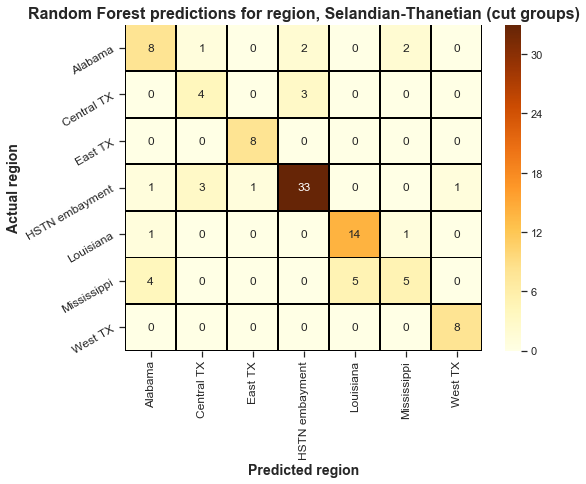

In [133]:
conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8,6))

plt.subplot(111)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.75, linecolor='black',
                 cmap='YlOrBr',
                xticklabels=new_labels,
                yticklabels=new_labels)
ax.set_ylabel('Actual region', fontsize=14, weight='bold', **a_font)
ax.set_xlabel('Predicted region', fontsize=14, weight='bold', **a_font)
ax.set_title('Random Forest predictions for region, Selandian-Thanetian (cut groups)', fontsize=16, weight='bold', y=1.05, **a_font)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, **a_font)
ax.set_yticklabels(ax.get_yticklabels(),rotation=30, **a_font)
ax.tick_params(labelsize=12)

plt.show()
# plt.savefig('RFC_Selandian_Thanetian_cut_groups_confusion_matrix.png',dpi=150,bbox_inches='tight', transparent=True)

In [131]:
print('\n\nClassification report for RFC of data:\n')
print(classification_report(y_test, y_pred, target_names=labels))



Classification report for RFC of data:

                precision    recall  f1-score   support

       Alabama       0.57      0.62      0.59        13
    Central TX       0.50      0.57      0.53         7
       East TX       0.89      1.00      0.94         8
HSTN embayment       0.87      0.85      0.86        39
     Louisiana       0.74      0.88      0.80        16
   Mississippi       0.62      0.36      0.45        14
       West TX       0.89      1.00      0.94         8

     micro avg       0.76      0.76      0.76       105
     macro avg       0.73      0.75      0.73       105
  weighted avg       0.76      0.76      0.75       105



In [135]:
## Feature importances
print(feature_importances)

                               importance
Delt_leavigato                   0.189603
Carya_Momipites                  0.130038
Holko-Rhoi                       0.127874
Gymnosperms                      0.124113
Triatriopollenites grp.          0.121975
Palms grp.                       0.113270
Favitricolporites baculoferus    0.106215
Freshwater algae                 0.086913


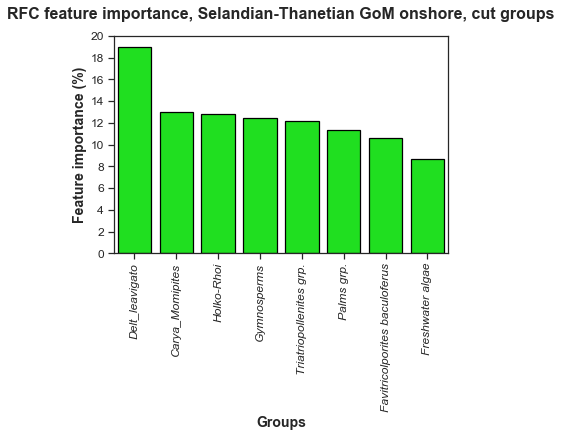

In [170]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

sns.set(style="ticks", font = 'arial')
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.barplot(feature_importances.index[:21], feature_importances['importance'][:21]*100,
                 alpha=1,color="#00ff00", linewidth=1)
plt.setp(ax.patches, linewidth=1.25, edgecolor='black')

#Over-ride the ytick mark frequency
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

ax.set_title('RFC feature importance, Selandian-Thanetian GoM onshore, cut groups', fontsize=16, weight='bold',y=1.05,**a_font)
ax.set_ylabel('Feature importance (%)', fontsize=14, weight='bold', **a_font)
ax.set_xlabel('Groups', fontsize=14, weight='bold', **a_font)
ax.tick_params(labelsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, **itals, **a_font)
ax.set(ylim=(0, 20))


plt.show()
# plt.savefig('RFC_Selandian_Thanetian_cut_groups_feature_importance.png',dpi=150,bbox_inches='tight', transparent=True)

# ONSHORE PCA Selandian-Thanetian

## PCA by palaeoenvironmental group

In [18]:
##Load the palaeonenvironmental data:

df = pd.read_csv('Master_all_terrestrial_palaeoenvironments_hellinger.csv').drop('Unnamed: 0', axis=1)
df.head(5)

,STUDY,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,REGION,...,TYPE,ANALYST,Bisaccates,Subtropical.Grp,Cool.temperate.Grp,Normapolle.Grp,Warm.temperate.Grp,Pteridophytes,Coastal.swamp.taxa,Thomsonipollis.magnificus
0,Perdido,Perdido,25.658354,-95.026684,Late Miocene,Tortonian,Frio,NaN,NaN,Perdido,...,CU,MENB,0.707107,0.288675,0.408248,0.0,0.000000,0.000000,0.500000,0.0
1,Perdido,Perdido,25.658354,-95.026684,Late Miocene,Tortonian,Frio,NaN,NaN,Perdido,...,CU,MENB,0.447214,0.387298,0.316228,0.0,0.387298,0.447214,0.447214,0.0
2,Perdido,Perdido,25.658354,-95.026684,Late Miocene-Middle Miocene,Tortonian-Serravallian,Frio,NaN,NaN,Perdido,...,CU,MENB,0.500000,0.250000,0.000000,0.0,0.250000,0.612372,0.500000,0.0
3,Perdido,Perdido,25.658354,-95.026684,Middle Miocene,Serravallian,Frio,NaN,NaN,Perdido,...,CU,MENB,0.688247,0.397360,0.000000,0.0,0.000000,0.458831,0.397360,0.0
4,Perdido,Perdido,25.658354,-95.026684,Middle Miocene,Langhian,Frio,NaN,NaN,Perdido,...,CU,MENB,0.745356,0.000000,0.000000,0.0,0.333333,0.577350,0.000000,0.0


In [19]:
df.STAGE.unique()

array(['Tortonian', 'Tortonian-Serravallian', 'Serravallian', 'Langhian',
       'Langhian?-Burdigalian', 'Chattian', 'Rupelian',
       'Chattian-Rupelian', 'Priabonian', nan, 'Bartonian', 'Lutetian',
       'Ypresian', 'Thanetian', 'Selandian', 'Selandian?', 'Danian',
       'Bartonian-Lutetian', 'Danian?', 'Selandian-Danian', '?Ypresian',
       '?Priabonian', '?Thanetian'], dtype=object)

In [20]:
## Split off the ONSHORE data for the Selandian-Thanetian only.

onshore = df.loc[(df['STUDY'] == 'Onshore') & ((df['STAGE'] == 'Thanetian') | 
                 (df['STAGE'] == 'Selandian') |
                (df['STAGE'] == 'Selandian?') |
                (df['STAGE'] == '?Thanetian') |
                (df['STAGE'] == 'Selandian-Danian'))]
# df.STUDY.unique()

## Change the labels to letters for ease of plotting and display
# onshore.rename(columns={'Bisaccates':'a',
#                      'Subtropical.Grp':'b',
#                      'Cool.temperate.Grp':'c',
#                      'Normapolle.Grp':'d',
#                      'Warm.temperate.Grp':'e',
#                      'Pteridophytes':'f',
#                      'Coastal.swamp.taxa':'g',
#                      'Thomsonipollis.magnificus':'h'}, inplace=True)

In [21]:
onshore.SITE.unique()
# list(onshore.columns)

array(['ANGELINA', 'BLACKSTONE_ISAACS', 'BRIONES', 'BRUNI_MINERALS',
       'CHAPMAN', 'COKE', 'DANDERSON', 'HARRELL', 'KNIGHT', 'KOLODZ',
       'MOCZ', 'PENN_VIRG', 'SETTLEMYRE', 'SF_WING', 'TUCKABUM', 'UCB',
       'WAHALAK', 'WALMART', 'WCM', 'WOODLEY'], dtype=object)

In [25]:
onshore.shape

(785, 24)

### Functions

In [9]:
import math

def get_important_features(transformed_features, components_, columns):
    """
    This function will return the most "important" 
    features so we can determine which have the most
    effect on multi-dimensional scaling
    """
    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    return important_features
   
    # print ("Features by importance:\n", important_features)



In [10]:
sns.set_style("ticks")

def draw_vectors(transformed_features, components_, columns):
    """
    This funtion will project your *original* features
    onto your principal component feature-space, so that you can
    visualize how "important" each one was in the
    multi-dimensional scaling
    """

    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    ax = plt.axes()

    for i in range(num_columns):
    # Use an arrow to project each original feature as a
    # labeled vector on your principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.009, head_width=0.05, alpha=0.75)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='k', alpha=0.75, fontsize=10)

    return ax

### Colour map

In [27]:
regions = {'AL':'#1A9850',
          'MS':'#91CF60',
          'LA':'#D9EF8B',
           'E-TX':'#FFFFBF',
          'HSTN':'#FEE08B',
           'C-TX': '#FC8D59',
          'W-TX':'#D73027'}
source = {'East':'#91CF60',
         'West':'#D73027'}

areas = {'Green Canyon':'#1A9850',
          'Walker Ridge':'#91CF60',
          'Garden Banks':'#D9EF8B',
           'Sigsbee Escarpment':'#D9EF8B',
          'Keathley Canyon':'#FEE08B',
           'Alaminos Canyon': '#FEE08B',
          'Perdido':'#D73027'}

In [122]:
## Split off the palaeoenvironmental groups

# onshore.columns[16]
data_matrix = onshore.drop(onshore.iloc[:,0:16], axis=1) #drop the target from the df
data_matrix.columns

Index(['Bisaccates', 'Subtropical.Grp', 'Cool.temperate.Grp', 'Normapolle.Grp',
       'Warm.temperate.Grp', 'Pteridophytes', 'Coastal.swamp.taxa',
       'Thomsonipollis.magnificus'],
      dtype='object')

### PCA

In [123]:
'''
Run a PCA to create 3 new features (axis 1 and axis 2)
'''

#Create a PCA that retains 99% of variance
# pca = PCA(n_components=3, whiten=True)
pca = PCA(n_components=0.99, whiten=True) 

#Conduct PCA
pca_df = pca.fit_transform(data_matrix)

print('Original number of features: ', data_matrix.shape[1])
print('Reduced number of features: ', pca_df.shape[1])
print(pca.explained_variance_ratio_)

Original number of features:  8
Reduced number of features:  8
[0.25314584 0.18757829 0.15081679 0.1242705  0.10797871 0.08414073
 0.05986312 0.03220602]


In [124]:
##To extract the components (sample scores)

x1 = pca_df[:,0]
x2 = pca_df[:,1]
x3 = pca_df[:,2]
onshore['PCA1'] = x1
onshore['PCA2'] = x2
onshore['PCA3'] = x3

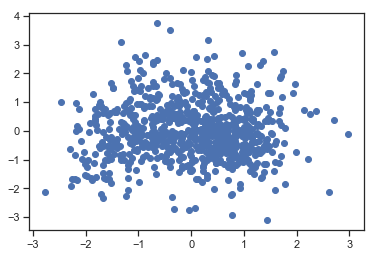

[0.25314584 0.18757829 0.15081679 0.1242705  0.10797871 0.08414073
 0.05986312 0.03220602]


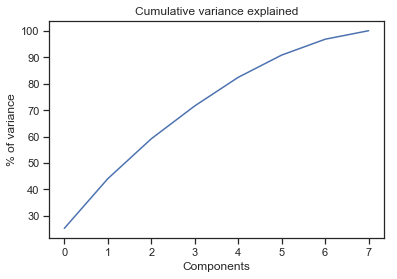

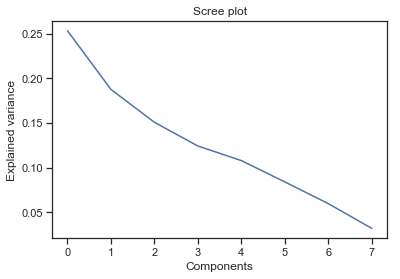

In [111]:
plt.scatter(x1,x2)
plt.show()

#The amount of variance that each PC explains
scree = pca.explained_variance_ratio_

#Cumulative Variance explains
cumvar = np.cumsum(np.round(scree, decimals=4)*100)

#Scree plot
print (scree)

plt.plot(cumvar)
plt.title('Cumulative variance explained')
plt.xlabel('Components')
plt.ylabel('% of variance')
plt.show()

plt.plot(scree)
plt.title('Scree plot')
plt.xlabel('Components')
plt.ylabel('Explained variance')
plt.show()

In [112]:
components = pd.DataFrame(pca.components_, columns = data_matrix.columns)
components

,a,b,c,d,e,f,g,h
0,-0.402464,0.159983,-0.101890,0.022561,-0.332462,0.611892,-0.411713,0.383519
1,-0.455835,-0.015347,0.080522,0.324617,0.425414,-0.489188,-0.193949,0.471403
2,-0.044533,-0.144735,0.072305,0.182237,-0.754632,-0.327720,0.399469,0.319664
3,0.660707,-0.311359,-0.124398,-0.108024,-0.037497,-0.119568,-0.484298,0.434893
4,0.220136,0.556191,0.161783,0.495761,-0.243092,-0.210383,-0.414961,-0.307722
5,-0.011810,0.635818,-0.154828,-0.650732,-0.047363,-0.313339,0.034778,0.215725
6,-0.039620,-0.086974,0.930835,-0.314182,-0.047776,0.023014,-0.149741,0.021600
7,-0.376234,-0.367560,-0.214083,-0.285120,-0.272024,-0.348732,-0.450481,-0.444611


In [125]:
get_important_features(pca_df, pca.components_, data_matrix.columns.values)


[(2.5846365094104535, 'Pteridophytes'),
 (2.1033579433987972, 'Thomsonipollis.magnificus'),
 (2.086517712520068, 'Bisaccates'),
 (1.876406293581963, 'Warm.temperate.Grp'),
 (1.4253400692046456, 'Coastal.swamp.taxa'),
 (1.2180894845277674, 'Normapolle.Grp'),
 (0.47993180012380715, 'Subtropical.Grp'),
 (0.4279031573136045, 'Cool.temperate.Grp')]

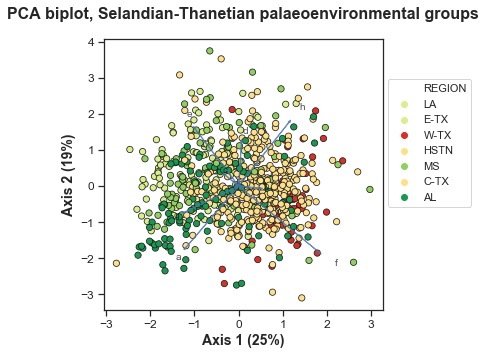

In [117]:
##Axis 1 vs. 2
plt.subplots(figsize=(5,5))
ax = draw_vectors(pca_df, pca.components_, data_matrix.columns.values)
ax = sns.scatterplot(x='PCA1', y='PCA2', hue='REGION', data=onshore, 
                     alpha=1, s=40,palette=regions, edgecolor='k')
ax.set_title('PCA biplot, Selandian-Thanetian palaeoenvironmental groups', fontsize=16, weight='bold', y=1.05)
ax.set_ylabel('Axis 2 (19%)', fontsize=14, weight='bold')
ax.set_xlabel('Axis 1 (25%)', fontsize=14, weight='bold')
ax.tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.85),loc=2, borderaxespad=0.) #Plot legend outside area
plt.savefig('PCA_selandian_thanetian_palaeoenvironments.eps',dpi=150,bbox_inches='tight', transparent=True)
# plt.show()

In [68]:
onshore.REGION.unique()

array(['LA', 'E-TX', 'W-TX', 'HSTN', 'MS', 'C-TX', 'AL'], dtype=object)

In [69]:
onshore.columns

Index(['STUDY', 'AREA', 'LAT', 'LONG', 'AGE', 'STAGE', 'GRP', 'ZONE',
       'SUBZONE', 'REGION', 'SAMPLE', 'SITE', 'TOP', 'BASE', 'TYPE', 'ANALYST',
       'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'PCA1', 'PCA2', 'PCA3'],
      dtype='object')

__Take home__

These data (just a few groups) are not showing strong distinctions although there is a general east-west split as shown by the biplot. It's just messy and the scree plot doesn't show a clear elbow. More subtle groups are needed. Use the full terrestrial taxa groups rather than by palaeoenvironmental label.

## PCA of all groups

In [27]:
## Load file if necessary but run the PCA functions from above. Use the cleaned version without extraneous caved taxa.

sel_than = pd.read_csv('Nonprop_onshore_cleaned_selandian_thanetian.csv').drop(['Y','Unnamed: 0'], axis=1)
sel_than.head()

,SOURCE,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,...,Retitrescolputes anguloluminosus,Rhoipites angustus,Rhoipites cryptoporus,Spinaepollis spinosus,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.
0,East,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,...,0.056433,0.000000,0.138233,0.195491,0.159617,0.356915,0.000000,0.097745,0.0,0.056433
1,East,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,...,0.000000,0.130466,0.130466,0.065233,0.112987,0.380369,0.112987,0.000000,0.0,0.065233
2,East,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,...,0.129641,0.091670,0.158777,0.112272,0.158777,0.366679,0.091670,0.064820,0.0,0.000000
3,East,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,...,0.092450,0.092450,0.172958,0.065372,0.269536,0.345916,0.092450,0.065372,0.0,0.000000
4,East,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,...,0.101274,0.160128,0.202548,0.124035,0.258199,0.464095,0.000000,0.071611,0.0,0.143223


In [32]:
# sel_than.SITE.unique()
list(sel_than.columns)

['P_REGION',
 'AREA',
 'LAT',
 'LONG',
 'AGE',
 'STAGE',
 'GRP',
 'ZONE',
 'SUBZONE',
 'TOP',
 'BASE',
 'TYPE',
 'ANALYST',
 'REGION',
 'LABEL',
 'SITE',
 'N',
 'S',
 'R100',
 'St dev',
 'E1/D',
 'Freshwater algae',
 'Alnipollenites verus',
 'Baculatisporites/Osmunda grp.',
 'Bagelopollis verrucatus',
 'Bisaccates',
 'Bombacacidites spp.',
 'Caprifoliipites viridifluminis',
 'Caryapollenites spp.',
 'Celtispollenites spp.',
 'Chenopodipollenites grp.',
 'Cicatricosisporites grp.',
 'Deltoidospora spp.',
 'Ephedra spp.',
 'Favitricolporites baculoferus',
 'Holkopollenites spp.',
 'Ilexpollenites grp.',
 'Inaperturopollenites spp.',
 'Kyandopollenites anneratus',
 'Labrapollis globosus',
 'Laevigatosporites spp.',
 'Lanagiopollis (Paleocene)',
 'Milfordia spp.',
 'Momipites actinus grp.',
 'Momipites grp.',
 'Palms grp.',
 'Pistillipollenites mcgregorii',
 'Polypodium type',
 'Proxapertites magnus',
 'Retitrescolputes anguloluminosus',
 'Rhoipites angustus',
 'Rhoipites cryptoporus',
 'S

In [61]:
## Drop columns of caved taxa
# sel_than.drop(['Annona foveoreticulata.',
#                'Engelhardtioidites spp.',
#                'Intratriporopollenites instructus',
#                'Ilexpollenites grp.',
#                'Intratriporopollenites cf instructus',
#                'Juglanspollenites grp.',
#                'Lanagiopollis (Eocene) grp.',
#                'Quercoidites',
#                'Retistephanocolporites',
#                'Rhoipites capax-latus',
#                'Tetracolporates grp.'], axis=1,inplace=True)

# sel_than.head()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Retitrescolputes anguloluminosus,Rhoipites angustus,Rhoipites cryptoporus,Spinaepollis spinosus,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.
0,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.056433,0.000000,0.138233,0.195491,0.159617,0.356915,0.000000,0.097745,0.0,0.056433
1,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.000000,0.130466,0.130466,0.065233,0.112987,0.380369,0.112987,0.000000,0.0,0.065233
2,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.129641,0.091670,0.158777,0.112272,0.158777,0.366679,0.091670,0.064820,0.0,0.000000
3,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.092450,0.092450,0.172958,0.065372,0.269536,0.345916,0.092450,0.065372,0.0,0.000000
4,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.101274,0.160128,0.202548,0.124035,0.258199,0.464095,0.000000,0.071611,0.0,0.143223


In [33]:
## Use the sel_than cleaned df from the preceeding steps. 
groups = sel_than.loc[:,'Freshwater algae':]
groups.shape

(524, 39)

In [34]:
'''
Run a PCA to create 3 new features (axis 1 and axis 2)
'''

#Create a PCA that retains 99% of variance
pca = PCA(n_components=0.99, whiten=True) 

#Conduct PCA
pca_df1 = pca.fit_transform(groups)

print('Original number of features: ', groups.shape[1])
print('Reduced number of features: ', pca_df1.shape[1])
print(pca.explained_variance_ratio_)

Original number of features:  39
Reduced number of features:  30
[0.21046216 0.13014904 0.08808069 0.07050117 0.06095399 0.05073157
 0.04409488 0.040577   0.03583037 0.02920639 0.026957   0.0240831
 0.01842312 0.01790282 0.01645608 0.01452363 0.01359766 0.0120987
 0.01164265 0.0109446  0.00974143 0.00938775 0.00834108 0.00731703
 0.00632714 0.00531513 0.00504238 0.00481725 0.00374308 0.00299281]


In [35]:
##To extract the components (sample scores)

x1 = pca_df1[:,0]
x2 = pca_df1[:,1]
x3 = pca_df1[:,2]
sel_than['PCA1'] = x1
sel_than['PCA2'] = x2
sel_than['PCA3'] = x3

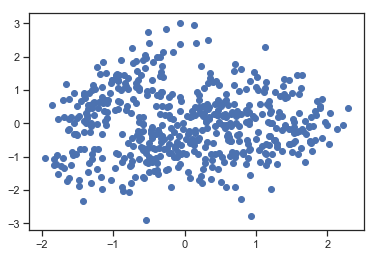

[0.21046216 0.13014904 0.08808069 0.07050117 0.06095399 0.05073157
 0.04409488 0.040577   0.03583037 0.02920639 0.026957   0.0240831
 0.01842312 0.01790282 0.01645608 0.01452363 0.01359766 0.0120987
 0.01164265 0.0109446  0.00974143 0.00938775 0.00834108 0.00731703
 0.00632714 0.00531513 0.00504238 0.00481725 0.00374308 0.00299281]


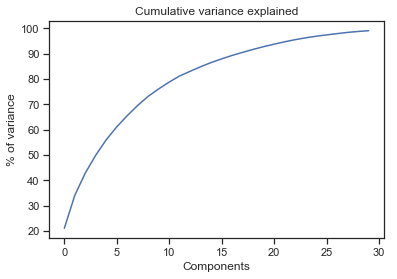

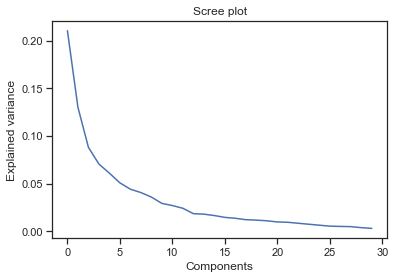

In [36]:
sns.set(style="ticks", font = 'arial')

plt.scatter(x1,x2)
plt.show()

#The amount of variance that each PC explains
scree = pca.explained_variance_ratio_

#Cumulative Variance explains
cumvar = np.cumsum(np.round(scree, decimals=4)*100)

#Scree plot
print (scree)

plt.plot(cumvar)
plt.title('Cumulative variance explained')
plt.xlabel('Components')
plt.ylabel('% of variance')
plt.show()

plt.plot(scree)
plt.title('Scree plot')
plt.xlabel('Components')
plt.ylabel('Explained variance')
plt.show()

In [37]:
components = pd.DataFrame(pca.components_, columns = groups.columns)
# components.to_csv('components.csv')

In [38]:
new_df= pd.DataFrame(get_important_features(pca_df1, pca.components_, groups.columns.values)[:11]) #get top 10 features

### Biplot

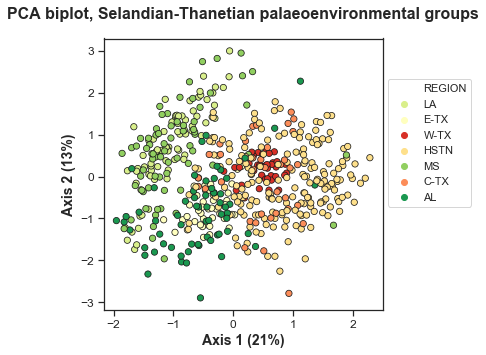

In [39]:
##Axis 1 vs. 2
sns.set(style="ticks", font = 'arial')

plt.subplots(figsize=(5,5))
# ax = draw_vectors(pca_df1, pca.components_, groups.columns.values)
ax = sns.scatterplot(x='PCA1', y='PCA2', hue='REGION', data=sel_than, 
                     alpha=1, s=40,palette=regions, edgecolor='k')
ax.set_title('PCA biplot, Selandian-Thanetian palaeoenvironmental groups', fontsize=16, weight='bold', y=1.05)
ax.set_ylabel('Axis 2 (13%)', fontsize=14, weight='bold')
ax.set_xlabel('Axis 1 (21%)', fontsize=14, weight='bold')
ax.tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.85),loc=2, borderaxespad=0.) #Plot legend outside area

# plt.savefig('PCA_selandian_thanetian.eps',dpi=300,bbox_inches='tight', transparent=True)
plt.show()

This shows a clearer distinction between major regions and a clear elbow on the scree plot.

In [76]:
## Split into East and West. Will be needed later!
east = ['E-TX', 'LA', 'AL', 'MS']

## Add a column condition based on a list 
sel_than['SOURCE'] = np.where(sel_than.REGION.isin(east),'East','West') #First val (x) is if true, 'y' if false

east_source = sel_than.loc[(sel_than.SOURCE == 'East')]
west_source = sel_than.loc[(sel_than.SOURCE == 'West')]

In [88]:
west_source.head()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.,PCA1,PCA2,PCA3,SOURCE
119,ONSHORE,TX,27.37822,-99.222389,Late_Paleocene,Thanetian,Wilcox,PPg6,0,7910.0,...,0.437479,0.218739,0.097823,0.0,0.0,0.0,0.348459,0.140181,0.738361,West
120,ONSHORE,TX,27.37822,-99.222389,Late_Paleocene,Thanetian,Wilcox,PPg6,0,7970.0,...,0.535149,0.216676,0.000000,0.0,0.0,0.0,0.412794,0.274033,0.946961,West
121,ONSHORE,TX,27.37822,-99.222389,Late_Paleocene,Thanetian,Wilcox,PPg6,0,8030.0,...,0.479808,0.084819,0.084819,0.0,0.0,0.0,0.721283,0.226816,1.404268,West
122,ONSHORE,TX,27.37822,-99.222389,Late_Paleocene,Thanetian,Wilcox,PPg6,0,8090.0,...,0.248891,0.094072,0.000000,0.0,0.0,0.0,-0.154491,0.124691,1.555933,West
123,ONSHORE,TX,27.37822,-99.222389,Late_Paleocene,Thanetian,Wilcox,PPg6,0,8150.0,...,0.228416,0.093250,0.000000,0.0,0.0,0.0,0.191693,-0.512430,1.881188,West


In [65]:
groups.columns.values

array(['Freshwater algae', 'Alnipollenites verus',
       'Annona foveoreticulata.', 'Baculatisporites/Osmunda grp.',
       'Bagelopollis verrucatus', 'Bisaccates', 'Bombacacidites spp.',
       'Brosipollis spp.', 'Caprifoliipites viridifluminis',
       'Caryapollenites spp.', 'Celtispollenites spp.',
       'Chenopodipollenites grp.', 'Cicatricosisporites grp.',
       'Deltoidospora spp.', 'Ephedra spp.',
       'Favitricolporites baculoferus', 'Holkopollenites spp.',
       'Inaperturopollenites spp.', 'Kyandopollenites anneratus',
       'Labrapollis globosus', 'Laevigatosporites spp.',
       'Lanagiopollis (Paleocene)', 'Milfordia spp.',
       'Momipites actinus grp.', 'Momipites grp.', 'Palms grp.',
       'Pistillipollenites mcgregorii', 'Platycaryapollenites spp.',
       'Polypodium type', 'Proxapertites magnus',
       'Retitrescolputes anguloluminosus', 'Rhoipites angustus',
       'Rhoipites cryptoporus', 'Spinaepollis spinosus',
       'Thomsonipollis magnificus', 'Tr

### Heatmap

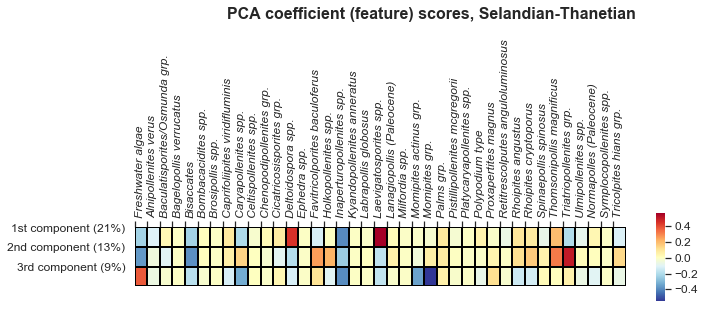

In [47]:
sns.set(font = 'arial')
plt.subplots(figsize=(11,1))
ax=plt.subplot(111)
sns.heatmap(pca.components_[:3], cmap='RdYlBu_r', linewidth=1,linecolor='black',
           cbar_kws={'label': '', 'shrink': 1.5, 'aspect':10})
plt.tick_params(labelsize=12)
plt.suptitle('PCA coefficient (feature) scores, Selandian-Thanetian', weight='bold', fontsize=16, y=4, **a_font)
plt.subplots_adjust(top=0.94)
ax.xaxis.set_ticks_position('top')
plt.xticks(range(len(groups.columns)),groups.columns, rotation=90, ha='left', **a_font, **itals, fontsize=12)
plt.yticks([0, 1, 2], ['1st component (21%)', '2nd component (13%)', '3rd component (9%)'], 
           **a_font, fontsize=12, rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

plt.savefig('PCA_feature_scores_Selandian-Thanetian.jpeg',dpi=300,bbox_inches='tight', transparent=True)
# plt.show()

In [52]:
new_df.columns = ['Component score', 'Group']
new_df.head()

,Component score,Group
0,1.578401,Triatriopollenites grp.
1,1.395297,Laevigatosporites spp.
2,1.245027,Bisaccates
3,1.198467,Freshwater algae
4,1.186361,Deltoidospora spp.


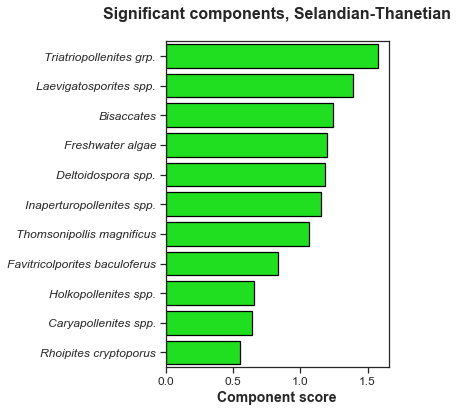

In [59]:
sns.set(style="ticks", font='Arial')

fig, ax = plt.subplots(figsize=(4,6))
ax = sns.barplot(y=new_df['Group'], x=new_df['Component score'],
                 alpha=1,color='#00ff00', linewidth=1, edgecolor='k')
plt.setp(ax.patches, linewidth=1.25, edgecolor='black')
ax.set_title('Significant components, Selandian-Thanetian', fontsize=16, weight='bold',y=1.05, **a_font)
ax.set_xlabel('Component score', fontsize=14, weight='bold', **a_font)
ax.set_ylabel('')
ax.tick_params(labelsize=12)
ax.set_yticklabels(ax.get_yticklabels(),**a_font, **itals)

# plt.show()
plt.savefig('Important_components_Selandian-Thanetian.eps',dpi=300,bbox_inches='tight', transparent=True)


In [97]:
# plt.matshow(pca.components_ [:3], cmap='RdYlBu_r')
# plt.title('PCA coefficient (feature) scores, Selandian-Thanetian', fontsize=16, weight='bold', y=3.85, **a_font)
# plt.yticks([0, 1, 2], ['1st component (21%)', '2nd component (13%)', '3rd component (9%)'], **a_font, fontsize=12)
# plt.colorbar()
# plt.xticks(range(len(groups.columns)),groups.columns, rotation=60, ha='left', **a_font, **itals, fontsize=12)
# plt.show()

## OFFSHORE PCA 

In [29]:
## Load file if necessary but run the PCA functions from above.

sel_than_off = pd.read_csv('sel_than_offshore.csv').drop('Unnamed: 0', axis=1)
sel_than_off.head()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Rhoipites capax-latus,Rhoipites cryptoporus,Spinaepollis spinosus,Tetracolporates grp.,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.
0,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33350.0,...,0.0,0.0,0.000000,0.0,0.249351,0.176318,0.0,0.000000,0.000000,0.0
1,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33380.0,...,0.0,0.0,0.000000,0.0,0.176227,0.294884,0.0,0.000000,0.078811,0.0
2,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33410.0,...,0.0,0.0,0.071247,0.0,0.236300,0.174519,0.0,0.071247,0.000000,0.0
3,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33440.0,...,0.0,0.0,0.000000,0.0,0.233762,0.147844,0.0,0.073922,0.000000,0.0
4,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33470.0,...,0.0,0.0,0.000000,0.0,0.294392,0.200000,0.0,0.081650,0.000000,0.0


In [30]:
sel_than_off.columns

Index(['P_REGION', 'AREA', 'LAT', 'LONG', 'AGE', 'STAGE', 'GRP', 'ZONE',
       'SUBZONE', 'TOP', 'BASE', 'TYPE', 'ANALYST', 'REGION', 'LABEL', 'SITE',
       'N', 'S', 'R100', 'St dev', 'E1/D', 'Freshwater algae',
       'Alnipollenites verus', 'Annona foveoreticulata.',
       'Baculatisporites/Osmunda grp.', 'Bagelopollis verrucatus',
       'Bisaccates', 'Bombacacidites spp.', 'Brosipollis spp.',
       'Caprifoliipites viridifluminis', 'Caryapollenites spp.',
       'Celtispollenites spp.', 'Chenopodipollenites grp.',
       'Cicatricosisporites grp.', 'Deltoidospora spp.',
       'Engelhardtioidites spp.', 'Ephedra spp.',
       'Favitricolporites baculoferus', 'Holkopollenites spp.',
       'Intratriporopollenites instructus', 'Ilexpollenites grp.',
       'Inaperturopollenites spp.', 'Intratriporopollenites cf instructus',
       'Juglanspollenites grp.', 'Kyandopollenites anneratus',
       'Labrapollis globosus', 'Laevigatosporites spp.',
       'Lanagiopollis (Paleocene)', '

In [31]:
## Drop columns of caved taxa
sel_than_off.drop(['Annona foveoreticulata.',
               'Engelhardtioidites spp.',
               'Intratriporopollenites instructus',
               'Ilexpollenites grp.',
               'Intratriporopollenites cf instructus',
               'Juglanspollenites grp.',
               'Lanagiopollis (Eocene) grp.',
               'Quercoidites',
               'Retistephanocolporites',
               'Rhoipites capax-latus',
               'Tetracolporates grp.'], axis=1,inplace=True)

sel_than_off.head()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Retitrescolputes anguloluminosus,Rhoipites angustus,Rhoipites cryptoporus,Spinaepollis spinosus,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.
0,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33350.0,...,0.0,0.071982,0.0,0.000000,0.249351,0.176318,0.0,0.000000,0.000000,0.0
1,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33380.0,...,0.0,0.136505,0.0,0.000000,0.176227,0.294884,0.0,0.000000,0.078811,0.0
2,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33410.0,...,0.0,0.000000,0.0,0.071247,0.236300,0.174519,0.0,0.071247,0.000000,0.0
3,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33440.0,...,0.0,0.000000,0.0,0.000000,0.233762,0.147844,0.0,0.073922,0.000000,0.0
4,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33470.0,...,0.0,0.081650,0.0,0.000000,0.294392,0.200000,0.0,0.081650,0.000000,0.0


In [32]:
## Use the sel_than cleaned df from the preceeding steps. 
groups = sel_than_off.loc[:,'Freshwater algae':]
groups.shape

(1502, 39)

In [33]:
'''
Run a PCA to create 3 new features (axis 1 and axis 2)
'''

#Create a PCA that retains 99% of variance
pca = PCA(n_components=0.99, whiten=True) 

#Conduct PCA
pca_df1 = pca.fit_transform(groups)

print('Original number of features: ', groups.shape[1])
print('Reduced number of features: ', pca_df1.shape[1])
print(pca.explained_variance_ratio_)

Original number of features:  39
Reduced number of features:  29
[0.16197264 0.12321985 0.09672138 0.07425184 0.05636898 0.0527658
 0.04415643 0.03487729 0.02938288 0.02761799 0.02329526 0.02238393
 0.02065737 0.01930302 0.01875692 0.01828723 0.01782235 0.01727548
 0.01629156 0.01605163 0.01522382 0.01361842 0.01359177 0.01213867
 0.01138988 0.00964552 0.0094261  0.00803855 0.00717999]


In [34]:
##To extract the components (sample scores)

x1 = pca_df1[:,0]
x2 = pca_df1[:,1]
x3 = pca_df1[:,2]
sel_than_off['PCA1'] = x1
sel_than_off['PCA2'] = x2
sel_than_off['PCA3'] = x3

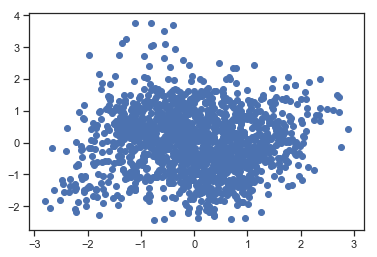

[0.16197264 0.12321985 0.09672138 0.07425184 0.05636898 0.0527658
 0.04415643 0.03487729 0.02938288 0.02761799 0.02329526 0.02238393
 0.02065737 0.01930302 0.01875692 0.01828723 0.01782235 0.01727548
 0.01629156 0.01605163 0.01522382 0.01361842 0.01359177 0.01213867
 0.01138988 0.00964552 0.0094261  0.00803855 0.00717999]


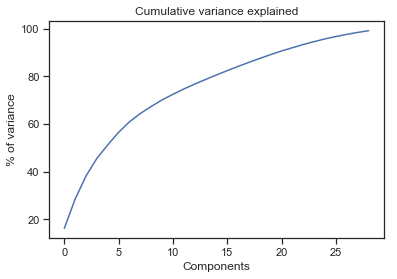

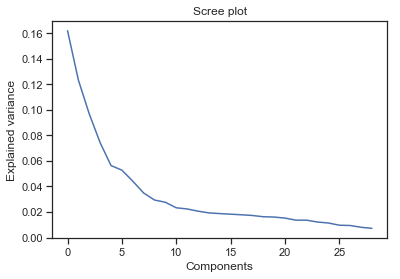

In [35]:
sns.set(style="ticks", font = 'arial')

plt.scatter(x1,x2)
plt.show()

#The amount of variance that each PC explains
scree = pca.explained_variance_ratio_

#Cumulative Variance explains
cumvar = np.cumsum(np.round(scree, decimals=4)*100)

#Scree plot
print (scree)

plt.plot(cumvar)
plt.title('Cumulative variance explained')
plt.xlabel('Components')
plt.ylabel('% of variance')
plt.show()

plt.plot(scree)
plt.title('Scree plot')
plt.xlabel('Components')
plt.ylabel('Explained variance')
plt.show()

In [36]:
components = pd.DataFrame(pca.components_, columns = groups.columns)
# components.to_csv('components.csv')

In [37]:
get_important_features(pca_df1, pca.components_, groups.columns.values)[:11] #get top 10 features

[(2.6209806062317846, 'Bisaccates'),
 (1.8153059240902838, 'Momipites grp.'),
 (1.4970832067383624, 'Thomsonipollis magnificus'),
 (1.4256371367633915, 'Triatriopollenites grp.'),
 (1.1096343915391904, 'Deltoidospora spp.'),
 (1.1067577890158649, 'Caryapollenites spp.'),
 (0.9123450154913716, 'Laevigatosporites spp.'),
 (0.7648142542103438, 'Rhoipites cryptoporus'),
 (0.749906065050102, 'Holkopollenites spp.'),
 (0.7197855226780289, 'Cicatricosisporites grp.'),
 (0.7057937768252305, 'Inaperturopollenites spp.')]

### Biplot

In [19]:
sel_than_off.AREA.unique()

array(['Keathley Canyon', 'Green Canyon', 'Alaminos Canyon',
       'Walker Ridge', 'Perdido', 'Garden Banks', 'Sigsbee Escarpment'],
      dtype=object)

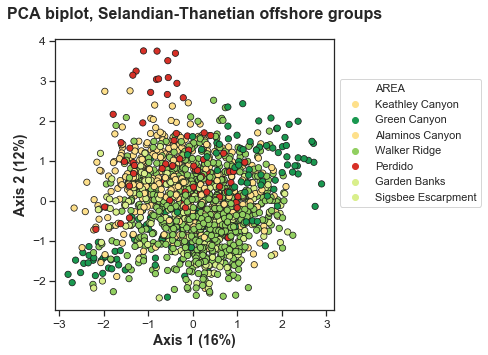

In [27]:
##Axis 1 vs. 2
sns.set(style="ticks", font = 'arial')

plt.subplots(figsize=(5,5))
ax = sns.scatterplot(x='PCA1', y='PCA2', hue='AREA', data=sel_than_off, 
                     alpha=1, s=40,palette=areas, edgecolor='k')
ax.set_title('PCA biplot, Selandian-Thanetian offshore groups', fontsize=16, weight='bold', y=1.05)
ax.set_ylabel('Axis 2 (12%)', fontsize=14, weight='bold')
ax.set_xlabel('Axis 1 (16%)', fontsize=14, weight='bold')
ax.tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.85),loc=2, borderaxespad=0.) #Plot legend outside area

# plt.savefig('PCA_selandian_thanetian_offshore.png',dpi=100,bbox_inches='tight', transparent=True)
plt.show()

The PCA on the offshore data of the same age as the onshore data indicates it is less clearly separated, messier and higher dimension. Different groups also appear to be more important than onshore.

In [38]:
groups.columns.values

array(['Freshwater algae', 'Alnipollenites verus',
       'Baculatisporites/Osmunda grp.', 'Bagelopollis verrucatus',
       'Bisaccates', 'Bombacacidites spp.', 'Brosipollis spp.',
       'Caprifoliipites viridifluminis', 'Caryapollenites spp.',
       'Celtispollenites spp.', 'Chenopodipollenites grp.',
       'Cicatricosisporites grp.', 'Deltoidospora spp.', 'Ephedra spp.',
       'Favitricolporites baculoferus', 'Holkopollenites spp.',
       'Inaperturopollenites spp.', 'Kyandopollenites anneratus',
       'Labrapollis globosus', 'Laevigatosporites spp.',
       'Lanagiopollis (Paleocene)', 'Milfordia spp.',
       'Momipites actinus grp.', 'Momipites grp.', 'Palms grp.',
       'Pistillipollenites mcgregorii', 'Platycaryapollenites spp.',
       'Polypodium type', 'Proxapertites magnus',
       'Retitrescolputes anguloluminosus', 'Rhoipites angustus',
       'Rhoipites cryptoporus', 'Spinaepollis spinosus',
       'Thomsonipollis magnificus', 'Triatriopollenites grp.',
       'Ul

### Heatmap

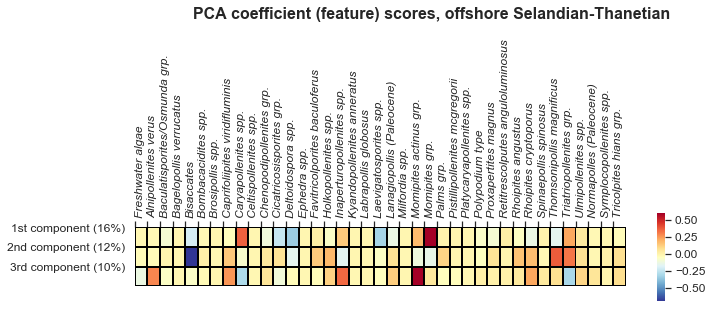

In [40]:
sns.set(font = 'arial')
plt.subplots(figsize=(11,1))
ax=plt.subplot(111)
sns.heatmap(pca.components_[:3], cmap='RdYlBu_r', linewidth=1,linecolor='black',
           cbar_kws={'label': '', 'shrink': 1.5, 'aspect':10})
plt.tick_params(labelsize=12)
plt.suptitle('PCA coefficient (feature) scores, offshore Selandian-Thanetian', weight='bold', fontsize=16, y=4, **a_font)
plt.subplots_adjust(top=0.94)
ax.xaxis.set_ticks_position('top')
plt.xticks(range(len(groups.columns)),groups.columns, rotation=90, ha='left', **a_font, **itals, fontsize=12)
plt.yticks([0, 1, 2], ['1st component (16%)', '2nd component (12%)', '3rd component (10%)'], 
           **a_font, fontsize=12, rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

plt.savefig('PCA_feature_scores_Selandian-Thanetian_offshore.jpeg',dpi=300,bbox_inches='tight', transparent=True)
# plt.show()

Compare this heatmap with that from the onshore data and it shows that different taxa are important for driving differences between samples in different offshore areas.

In [49]:
sel_than_off.to_csv('selandian_thanetian_offshore_PCA.csv')

# ONSHORE PCA on Ypresian samples

In [40]:
## load DF
ypres = pd.read_csv('ypres_cleaned_all.csv').drop('Unnamed: 0', axis=1)
ypres.head()

,SITE,P_REGION,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Spinaepollis.spinosus,Spinferites.grp,Spinidinium.spp.,Tetracolporates.grp,Thomsonipollis.magnificus,Triatriopollenites.grp,Ulmipollenites.spp.,Wetzeliella.grp,Wilsonidium.spp,Normapolles..Paleocene.
0,PEP,OFFSHORE,25.529718,-95.21308,Early Eocene,Ypresian,Wilcox,PPg7,PPg7a,0.0,...,0.0,0.244505,0.0,0.000000,0.221163,0.294884,0.073721,0.0,0.0,0.0000
1,PEP,OFFSHORE,25.529718,-95.21308,Early Eocene,Ypresian,Wilcox,PPg7,PPg7a,0.0,...,0.0,0.236801,0.0,0.096674,0.305709,0.273434,0.000000,0.0,0.0,0.0000
2,PEP,OFFSHORE,25.529718,-95.21308,Early Eocene,Ypresian,Wilcox,PPg7,PPg7a,0.0,...,0.0,0.106600,0.0,0.106600,0.213201,0.319801,0.150756,0.0,0.0,0.1066
3,PEP,OFFSHORE,25.529718,-95.21308,Early Eocene,Ypresian,Wilcox,PPg7,PPg7a,0.0,...,0.0,0.204124,0.0,0.000000,0.176777,0.228218,0.000000,0.0,0.0,0.0000
4,PEP,OFFSHORE,25.529718,-95.21308,Early Eocene,Ypresian,Wilcox,PPg7,PPg7a,0.0,...,0.0,0.156174,0.0,0.000000,0.246932,0.246932,0.000000,0.0,0.0,0.0000


In [49]:
#Subset the onshore sites only
ypres_on = ypres.loc[(ypres['P_REGION'] == 'ONSHORE')]
ypres_on.shape

(667, 101)

In [50]:
## cut redundant columns such as dinocysts and reworked stuff
ypres_on.drop(['Areosphaeridium.polypetellum',
 'Adnatosphaeridium.grp',
 'Apectodinium.grp',
 'Areoligera.spp',
 'Cribroperidinium.tenuitabulatum',
 'Cerodinium.Deflandrea.Lentina.grp',
 'Charlesdowniea.spp.',
 'Chiropteridium.spp.',
 'Cordosphaeridium.cpx',
 'Dinopterygium.Heteraulacysta.grp',
 'Diphyes.spp.',
 'Engelhardtioidites.spp.',
 'Eocladopyxis.spp',
 'Gerdiocysta.spp',
 'Glaphyrocysta.spp.',
 'Homotryblium.floripes.grp.',
 'Hystrichokolpoma.spp.',
 'Juglanspollenites.grp',
 'Kenleyia.grp',
 'Momipites.actinus.grp',
 'Muratodinium.spp.',
 'Polysphaeridium.spp',
 'Quercoidites',
 'Systematophora.placacantha.grp',
 'Senegalinium.grp',
 'Sphaeromorph.acritarchs',
 'Spinferites.grp',
 'Spinidinium.spp.',
 'Wetzeliella.grp',
 'Wilsonidium.spp',
               'Odiosisphaera.wilcoxensis',
 'Operculodinium.spp',
 'Palaeoperidinium.pyrophorum'], axis=1, inplace=True)

In [51]:
list(ypres_on.columns)

['SITE',
 'P_REGION',
 'LAT',
 'LONG',
 'AGE',
 'STAGE',
 'GRP',
 'ZONE',
 'SUBZONE',
 'TOP',
 'BASE',
 'TYPE',
 'ANALYST',
 'REGION',
 'LABEL',
 'STATE',
 'N',
 'S',
 'R100',
 'St.dev',
 'E1.D',
 'AXIS1_jac',
 'AXIS2_jac',
 'AXIS3_jac',
 'Freshwater.algae',
 'Alnipollenites.verus',
 'Annona.foveoreticulata.',
 'Baculatisporites.Osmunda.grp',
 'Bagelopollis.verrucatus',
 'Bisaccates',
 'Bombacacidites.spp.',
 'Brosipollis.spp.',
 'Caprifoliipites.viridifluminis',
 'Caryapollenites.spp.',
 'Celtispollenites.spp',
 'Chenopodipollenites.grp',
 'Cicatricosisporites.grp',
 'Deltoidospora.spp.',
 'Ephedra.spp.',
 'Favitricolporites.baculoferus',
 'Holkopollenites.spp.',
 'Intratriporopollenites.instructus',
 'Ilexpollenites.grp',
 'Inaperturopollenites.spp.',
 'Intratriporopollenites.cf.instructus',
 'Kyandopollenites.anneratus',
 'Labrapollis.globosus',
 'Laevigatosporites.spp.',
 'Lanagiopollis..Paleocene.',
 'Lanagiopollis..Eocene..grp',
 'Milfordia.spp.',
 'Momipites.grp',
 'Palms.grp',


In [56]:
# Replace dots and strip trailing white space
column_names = list(ypres_on.columns.values)
column_names = [item.replace('.', ' ') for item in column_names]
column_names = [x.rstrip(' ') for x in column_names]
column_names = [item.replace('spp', 'spp.') for item in column_names]
column_names = [item.replace('grp', 'Grp.') for item in column_names]

ypres_on.columns = column_names #reassign back to column headers

In [57]:
ypres_on.columns

Index(['SITE', 'P_REGION', 'LAT', 'LONG', 'AGE', 'STAGE', 'GRP', 'ZONE',
       'SUBZONE', 'TOP', 'BASE', 'TYPE', 'ANALYST', 'REGION', 'LABEL', 'STATE',
       'N', 'S', 'R100', 'St dev', 'E1 D', 'AXIS1_jac', 'AXIS2_jac',
       'AXIS3_jac', 'Freshwater algae', 'Alnipollenites verus',
       'Annona foveoreticulata', 'Baculatisporites Osmunda Grp.',
       'Bagelopollis verrucatus', 'Bisaccates', 'Bombacacidites spp.',
       'Brosipollis spp.', 'Caprifoliipites viridifluminis',
       'Caryapollenites spp.', 'Celtispollenites spp.',
       'Chenopodipollenites Grp.', 'Cicatricosisporites Grp.',
       'Deltoidospora spp.', 'Ephedra spp.', 'Favitricolporites baculoferus',
       'Holkopollenites spp.', 'Intratriporopollenites instructus',
       'Ilexpollenites Grp.', 'Inaperturopollenites spp.',
       'Intratriporopollenites cf instructus', 'Kyandopollenites anneratus',
       'Labrapollis globosus', 'Laevigatosporites spp.',
       'Lanagiopollis  Paleocene', 'Lanagiopollis  Eocene 

In [59]:
ypres_on.rename(columns={'Baculatisporites Osmunda Grp.':'Baculatisporites/Osmunda Grp.',
                   'Intratriporopollenites cf instructus':'Intratriporopollenites cf. instructus',
                   'Lanagiopollis  Paleocene':'Lanagiopollis (Paleocene types)',
                       'Lanagiopollis  Eocene  Grp.':'Lanagiopollis (Eocene types)',
                        'Momipites Grp.':'Momipites spp.',
                        'Rhoipites capax latus':'Rhoipites capax/latus',
                         'Normapolles  Paleocene':'Normapolles (Paleocene types)'}, inplace=True)

In [60]:
## Use the sel_than cleaned df from the preceeding steps. 
groups = ypres_on.loc[:,'Freshwater algae':]
groups.shape

(667, 44)

In [61]:
'''
Run a PCA to create 3 new features (axis 1 and axis 2)
'''

#Create a PCA that retains 99% of variance
pca = PCA(n_components=0.99, whiten=True) 

#Conduct PCA
pca_df2 = pca.fit_transform(groups)

print('Original number of features: ', groups.shape[1])
print('Reduced number of features: ', pca_df2.shape[1])
print(pca.explained_variance_ratio_)

Original number of features:  44
Reduced number of features:  34
[0.16851965 0.14990048 0.10294505 0.08987153 0.07708693 0.05817961
 0.05206086 0.03525321 0.03505334 0.02271106 0.02106098 0.01844865
 0.01647693 0.01451723 0.01277057 0.01217058 0.01055668 0.00985552
 0.00938373 0.00850124 0.00732497 0.00713926 0.00605046 0.00568257
 0.0055362  0.00494339 0.00482306 0.0046332  0.00431021 0.00402178
 0.00353788 0.00309283 0.00262614 0.00240531]


In [62]:
##To extract the components (sample scores)

x1 = pca_df2[:,0]
x2 = pca_df2[:,1]
x3 = pca_df2[:,2]
ypres_on['PCA1'] = x1
ypres_on['PCA2'] = x2
ypres_on['PCA3'] = x3

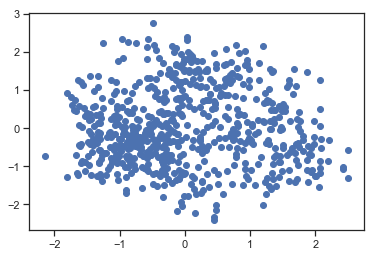

[0.16851965 0.14990048 0.10294505 0.08987153 0.07708693 0.05817961
 0.05206086 0.03525321 0.03505334 0.02271106 0.02106098 0.01844865
 0.01647693 0.01451723 0.01277057 0.01217058 0.01055668 0.00985552
 0.00938373 0.00850124 0.00732497 0.00713926 0.00605046 0.00568257
 0.0055362  0.00494339 0.00482306 0.0046332  0.00431021 0.00402178
 0.00353788 0.00309283 0.00262614 0.00240531]


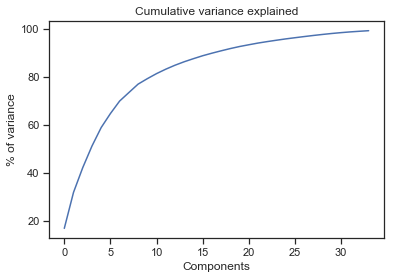

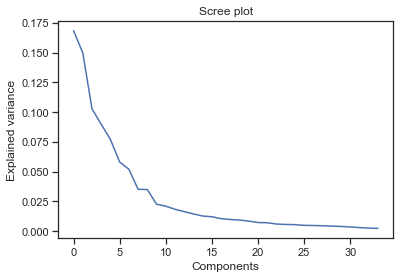

In [63]:
sns.set(style="ticks", font = 'arial')

plt.scatter(x1,x2)
plt.show()

#The amount of variance that each PC explains
scree = pca.explained_variance_ratio_

#Cumulative Variance explains
cumvar = np.cumsum(np.round(scree, decimals=4)*100)

#Scree plot
print (scree)

plt.plot(cumvar)
plt.title('Cumulative variance explained')
plt.xlabel('Components')
plt.ylabel('% of variance')
plt.show()

plt.plot(scree)
plt.title('Scree plot')
plt.xlabel('Components')
plt.ylabel('Explained variance')
plt.show()

In [64]:
components = pd.DataFrame(pca.components_, columns = groups.columns)
# components.to_csv('components.csv')

In [65]:
new_df= pd.DataFrame(get_important_features(pca_df2, pca.components_, groups.columns.values)[:11]) #get top 10 features

### Biplot

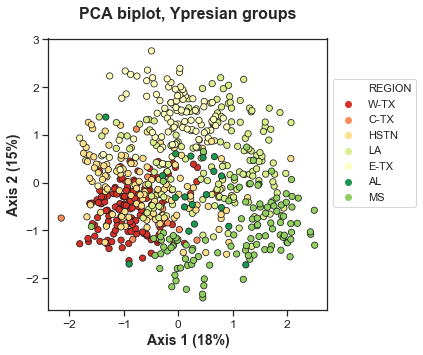

In [71]:
##Axis 1 vs. 2
sns.set(style="ticks", font = 'arial')

plt.subplots(figsize=(5,5))
# ax = draw_vectors(pca_df1, pca.components_, groups.columns.values)
ax = sns.scatterplot(x='PCA1', y='PCA2', hue='REGION', data=ypres_on, 
                     alpha=1, s=40,palette=regions, edgecolor='k')
ax.set_title('PCA biplot, Ypresian groups', fontsize=16, weight='bold', y=1.05)
ax.set_ylabel('Axis 2 (15%)', fontsize=14, weight='bold')
ax.set_xlabel('Axis 1 (18%)', fontsize=14, weight='bold')
ax.tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.85),loc=2, borderaxespad=0.) #Plot legend outside area

plt.savefig('PCA_ypresian.eps',dpi=300,bbox_inches='tight', transparent=True)
# plt.show()

In [67]:
## Split into East and West
east = ['LA', 'AL', 'MS']

## Add a column condition based on a list 
ypres_on['SOURCE'] = np.where(ypres_on.REGION.isin(east),'East','West') #First val (x) is if true, 'y' if false

east_source = ypres_on.loc[(ypres_on.SOURCE == 'East')]
west_source = ypres_on.loc[(ypres_on.SOURCE == 'West')]

In [68]:
west_source.head()

,SITE,P_REGION,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Spinaepollis spinosus,Tetracolporates Grp.,Thomsonipollis magnificus,Triatriopollenites Grp.,Ulmipollenites spp.,Normapolles (Paleocene types),PCA1,PCA2,PCA3,SOURCE
996,HAYNES,ONSHORE,26.96738,-99.1153,Early_Eocene,Ypresian,Wilcox,PPg8,0,7800.0,...,0.0,0.0,0.228748,0.274921,0.152499,0.076249,-1.155455,-0.099403,-0.579601,West
997,HAYNES,ONSHORE,26.96738,-99.1153,Early_Eocene,Ypresian,Wilcox,PPg8,0,7830.0,...,0.0,0.0,0.262962,0.309426,0.126323,0.072932,-1.058616,0.337343,-0.811146,West
998,HAYNES,ONSHORE,26.96738,-99.1153,Early_Eocene,Ypresian,Wilcox,PPg8,0,7860.0,...,0.0,0.0,0.215666,0.304997,0.132068,0.076249,-0.903857,-0.156180,-0.655735,West
999,HAYNES,ONSHORE,26.96738,-99.1153,Early_Eocene,Ypresian,Wilcox,PPg8,0,7890.0,...,0.0,0.0,0.175142,0.303355,0.135665,0.078326,-1.110357,-0.807123,-0.542606,West
1000,HAYNES,ONSHORE,26.96738,-99.1153,Early_Eocene,Ypresian,Wilcox,PPg8,0,7920.0,...,0.0,0.0,0.235702,0.278887,0.149071,0.000000,-1.309853,-0.180355,-0.811699,West


In [69]:
groups.columns.values

array(['Freshwater algae', 'Alnipollenites verus',
       'Annona foveoreticulata', 'Baculatisporites/Osmunda Grp.',
       'Bagelopollis verrucatus', 'Bisaccates', 'Bombacacidites spp.',
       'Brosipollis spp.', 'Caprifoliipites viridifluminis',
       'Caryapollenites spp.', 'Celtispollenites spp.',
       'Chenopodipollenites Grp.', 'Cicatricosisporites Grp.',
       'Deltoidospora spp.', 'Ephedra spp.',
       'Favitricolporites baculoferus', 'Holkopollenites spp.',
       'Intratriporopollenites instructus', 'Ilexpollenites Grp.',
       'Inaperturopollenites spp.',
       'Intratriporopollenites cf. instructus',
       'Kyandopollenites anneratus', 'Labrapollis globosus',
       'Laevigatosporites spp.', 'Lanagiopollis (Paleocene types)',
       'Lanagiopollis (Eocene types)', 'Milfordia spp.', 'Momipites spp.',
       'Palms Grp.', 'Pistillipollenites mcgregorii',
       'Platycaryapollenites spp.', 'Polypodium type',
       'Proxapertites magnus', 'Retistephanocolporites',
  

### Heatmap

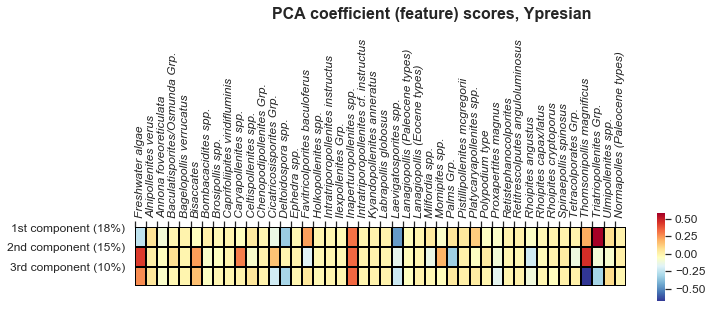

In [72]:
sns.set(font = 'arial')
plt.subplots(figsize=(11,1))
ax=plt.subplot(111)
sns.heatmap(pca.components_[:3], cmap='RdYlBu_r', linewidth=1,linecolor='black',
           cbar_kws={'label': '', 'shrink': 1.5, 'aspect':10})
plt.tick_params(labelsize=12)
plt.suptitle('PCA coefficient (feature) scores, Ypresian', weight='bold', fontsize=16, y=4, **a_font)
plt.subplots_adjust(top=0.94)
ax.xaxis.set_ticks_position('top')
plt.xticks(range(len(groups.columns)),groups.columns, rotation=90, ha='left', **a_font, **itals, fontsize=12)
plt.yticks([0, 1, 2], ['1st component (18%)', '2nd component (15%)', '3rd component (10%)'], 
           **a_font, fontsize=12, rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

plt.savefig('PCA_feature_scores_Ypresian.jpeg',dpi=300,bbox_inches='tight', transparent=True)
# plt.show()

In [73]:
new_df.columns = ['Component score', 'Group']
new_df.head()

,Component score,Group
0,1.482077,Triatriopollenites Grp.
1,1.373172,Thomsonipollis magnificus
2,1.347218,Freshwater algae
3,1.241758,Inaperturopollenites spp.
4,1.211124,Laevigatosporites spp.


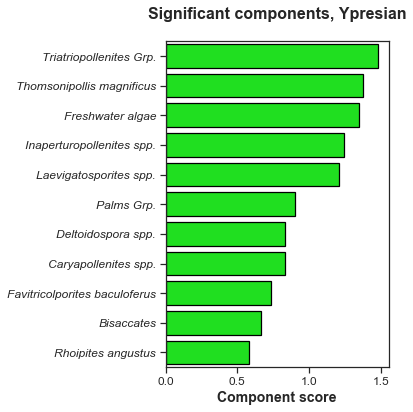

In [75]:
sns.set(style="ticks", font='Arial')

fig, ax = plt.subplots(figsize=(4,6))
ax = sns.barplot(y=new_df['Group'], x=new_df['Component score'],
                 alpha=1,color='#00ff00', linewidth=1, edgecolor='k')
plt.setp(ax.patches, linewidth=1.25, edgecolor='black')
ax.set_title('Significant components, Ypresian', fontsize=16, weight='bold',y=1.05, **a_font)
ax.set_xlabel('Component score', fontsize=14, weight='bold', **a_font)
ax.set_ylabel('')
ax.tick_params(labelsize=12)
ax.set_yticklabels(ax.get_yticklabels(),**a_font, **itals)

# plt.show()
plt.savefig('Important_components_Ypresian.eps',dpi=300,bbox_inches='tight', transparent=True)


In [88]:
len(ypres_on.columns[24:-4])
len(sel_than.columns[21:-3])

39

# OFFSHORE PCA on Ypresian samples

In [12]:
## load DF
ypres = pd.read_csv('ypres_cleaned_all.csv').drop('Unnamed: 0', axis=1)
ypres.head()

,SITE,P_REGION,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Spinaepollis.spinosus,Spinferites.grp,Spinidinium.spp.,Tetracolporates.grp,Thomsonipollis.magnificus,Triatriopollenites.grp,Ulmipollenites.spp.,Wetzeliella.grp,Wilsonidium.spp,Normapolles..Paleocene.
0,PEP,OFFSHORE,25.529718,-95.21308,Early Eocene,Ypresian,Wilcox,PPg7,PPg7a,0.0,...,0.0,0.244505,0.0,0.000000,0.221163,0.294884,0.073721,0.0,0.0,0.0000
1,PEP,OFFSHORE,25.529718,-95.21308,Early Eocene,Ypresian,Wilcox,PPg7,PPg7a,0.0,...,0.0,0.236801,0.0,0.096674,0.305709,0.273434,0.000000,0.0,0.0,0.0000
2,PEP,OFFSHORE,25.529718,-95.21308,Early Eocene,Ypresian,Wilcox,PPg7,PPg7a,0.0,...,0.0,0.106600,0.0,0.106600,0.213201,0.319801,0.150756,0.0,0.0,0.1066
3,PEP,OFFSHORE,25.529718,-95.21308,Early Eocene,Ypresian,Wilcox,PPg7,PPg7a,0.0,...,0.0,0.204124,0.0,0.000000,0.176777,0.228218,0.000000,0.0,0.0,0.0000
4,PEP,OFFSHORE,25.529718,-95.21308,Early Eocene,Ypresian,Wilcox,PPg7,PPg7a,0.0,...,0.0,0.156174,0.0,0.000000,0.246932,0.246932,0.000000,0.0,0.0,0.0000


In [13]:
ypres.P_REGION.unique()

array(['OFFSHORE', 'ONSHORE'], dtype=object)

In [14]:
#Subset the onshore sites only
ypres_off = ypres.loc[(ypres['P_REGION'] == 'OFFSHORE')]
ypres_off.shape

(1092, 101)

In [15]:
## cut redundant columns such as dinocysts and reworked stuff
ypres_off.drop(['Areosphaeridium.polypetellum',
 'Adnatosphaeridium.grp',
 'Apectodinium.grp',
 'Areoligera.spp',
 'Cribroperidinium.tenuitabulatum',
 'Cerodinium.Deflandrea.Lentina.grp',
 'Charlesdowniea.spp.',
 'Chiropteridium.spp.',
 'Cordosphaeridium.cpx',
 'Dinopterygium.Heteraulacysta.grp',
 'Diphyes.spp.',
 'Engelhardtioidites.spp.',
 'Eocladopyxis.spp',
 'Gerdiocysta.spp',
 'Glaphyrocysta.spp.',
 'Homotryblium.floripes.grp.',
 'Hystrichokolpoma.spp.',
 'Juglanspollenites.grp',
 'Kenleyia.grp',
 'Momipites.actinus.grp',
 'Muratodinium.spp.',
 'Polysphaeridium.spp',
 'Quercoidites',
 'Systematophora.placacantha.grp',
 'Senegalinium.grp',
 'Sphaeromorph.acritarchs',
 'Spinferites.grp',
 'Spinidinium.spp.',
 'Wetzeliella.grp',
 'Wilsonidium.spp',
               'Odiosisphaera.wilcoxensis',
 'Operculodinium.spp',
 'Palaeoperidinium.pyrophorum'], axis=1, inplace=True)

In [16]:
list(ypres_off.columns)

['SITE',
 'P_REGION',
 'LAT',
 'LONG',
 'AGE',
 'STAGE',
 'GRP',
 'ZONE',
 'SUBZONE',
 'TOP',
 'BASE',
 'TYPE',
 'ANALYST',
 'REGION',
 'LABEL',
 'STATE',
 'N',
 'S',
 'R100',
 'St.dev',
 'E1.D',
 'AXIS1_jac',
 'AXIS2_jac',
 'AXIS3_jac',
 'Freshwater.algae',
 'Alnipollenites.verus',
 'Annona.foveoreticulata.',
 'Baculatisporites.Osmunda.grp',
 'Bagelopollis.verrucatus',
 'Bisaccates',
 'Bombacacidites.spp.',
 'Brosipollis.spp.',
 'Caprifoliipites.viridifluminis',
 'Caryapollenites.spp.',
 'Celtispollenites.spp',
 'Chenopodipollenites.grp',
 'Cicatricosisporites.grp',
 'Deltoidospora.spp.',
 'Ephedra.spp.',
 'Favitricolporites.baculoferus',
 'Holkopollenites.spp.',
 'Intratriporopollenites.instructus',
 'Ilexpollenites.grp',
 'Inaperturopollenites.spp.',
 'Intratriporopollenites.cf.instructus',
 'Kyandopollenites.anneratus',
 'Labrapollis.globosus',
 'Laevigatosporites.spp.',
 'Lanagiopollis..Paleocene.',
 'Lanagiopollis..Eocene..grp',
 'Milfordia.spp.',
 'Momipites.grp',
 'Palms.grp',


In [17]:
# Replace dots and strip trailing white space
column_names = list(ypres_off.columns.values)
column_names = [item.replace('.', ' ') for item in column_names]
column_names = [x.rstrip(' ') for x in column_names]
column_names = [item.replace('spp', 'spp.') for item in column_names]
column_names = [item.replace('grp', 'Grp.') for item in column_names]

ypres_off.columns = column_names #reassign back to column headers

In [18]:
ypres_off.columns

Index(['SITE', 'P_REGION', 'LAT', 'LONG', 'AGE', 'STAGE', 'GRP', 'ZONE',
       'SUBZONE', 'TOP', 'BASE', 'TYPE', 'ANALYST', 'REGION', 'LABEL', 'STATE',
       'N', 'S', 'R100', 'St dev', 'E1 D', 'AXIS1_jac', 'AXIS2_jac',
       'AXIS3_jac', 'Freshwater algae', 'Alnipollenites verus',
       'Annona foveoreticulata', 'Baculatisporites Osmunda Grp.',
       'Bagelopollis verrucatus', 'Bisaccates', 'Bombacacidites spp.',
       'Brosipollis spp.', 'Caprifoliipites viridifluminis',
       'Caryapollenites spp.', 'Celtispollenites spp.',
       'Chenopodipollenites Grp.', 'Cicatricosisporites Grp.',
       'Deltoidospora spp.', 'Ephedra spp.', 'Favitricolporites baculoferus',
       'Holkopollenites spp.', 'Intratriporopollenites instructus',
       'Ilexpollenites Grp.', 'Inaperturopollenites spp.',
       'Intratriporopollenites cf instructus', 'Kyandopollenites anneratus',
       'Labrapollis globosus', 'Laevigatosporites spp.',
       'Lanagiopollis  Paleocene', 'Lanagiopollis  Eocene 

In [19]:
ypres_off.rename(columns={'Baculatisporites Osmunda Grp.':'Baculatisporites/Osmunda Grp.',
                   'Intratriporopollenites cf instructus':'Intratriporopollenites cf. instructus',
                   'Lanagiopollis  Paleocene':'Lanagiopollis (Paleocene types)',
                       'Lanagiopollis  Eocene  Grp.':'Lanagiopollis (Eocene types)',
                        'Momipites Grp.':'Momipites spp.',
                        'Rhoipites capax latus':'Rhoipites capax/latus',
                         'Normapolles  Paleocene':'Normapolles (Paleocene types)'}, inplace=True)

In [20]:
## Use the sel_than cleaned df from the preceeding steps. 
groups = ypres_off.loc[:,'Freshwater algae':]
groups.shape

(1092, 44)

In [21]:
'''
Run a PCA to create 3 new features (axis 1 and axis 2)
'''

#Create a PCA that retains 99% of variance
pca = PCA(n_components=0.99, whiten=True) 

#Conduct PCA
pca_df = pca.fit_transform(groups)

print('Original number of features: ', groups.shape[1])
print('Reduced number of features: ', pca_df.shape[1])
print(pca.explained_variance_ratio_)

Original number of features:  44
Reduced number of features:  34
[0.18198293 0.10043139 0.09444971 0.07879139 0.07218967 0.05581905
 0.04743283 0.03936203 0.03715852 0.02794032 0.02415256 0.02189283
 0.01986139 0.01885265 0.01768638 0.01597141 0.01435899 0.01387839
 0.0129673  0.01237951 0.01141114 0.00877401 0.00845289 0.00723879
 0.00673768 0.00608458 0.00588236 0.00547101 0.00513397 0.00468706
 0.00457033 0.00336571 0.002601   0.00219581]


In [22]:
##To extract the components (sample scores)

x1 = pca_df[:,0]
x2 = pca_df[:,1]
x3 = pca_df[:,2]
ypres_off['PCA1'] = x1
ypres_off['PCA2'] = x2
ypres_off['PCA3'] = x3

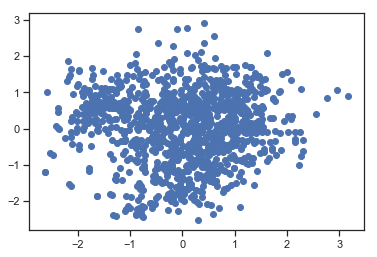

[0.18198293 0.10043139 0.09444971 0.07879139 0.07218967 0.05581905
 0.04743283 0.03936203 0.03715852 0.02794032 0.02415256 0.02189283
 0.01986139 0.01885265 0.01768638 0.01597141 0.01435899 0.01387839
 0.0129673  0.01237951 0.01141114 0.00877401 0.00845289 0.00723879
 0.00673768 0.00608458 0.00588236 0.00547101 0.00513397 0.00468706
 0.00457033 0.00336571 0.002601   0.00219581]


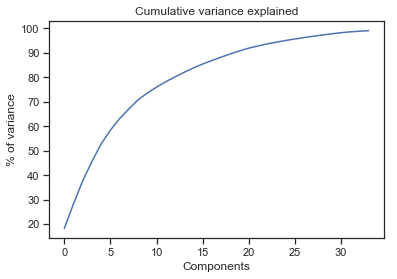

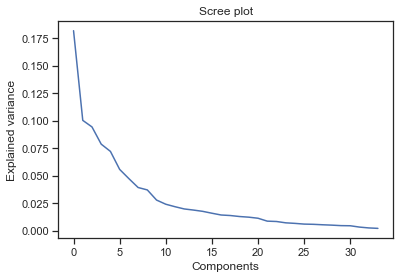

In [23]:
sns.set(style="ticks", font = 'arial')

plt.scatter(x1,x2)
plt.show()

#The amount of variance that each PC explains
scree = pca.explained_variance_ratio_

#Cumulative Variance explains
cumvar = np.cumsum(np.round(scree, decimals=4)*100)

#Scree plot
print (scree)

plt.plot(cumvar)
plt.title('Cumulative variance explained')
plt.xlabel('Components')
plt.ylabel('% of variance')
plt.show()

plt.plot(scree)
plt.title('Scree plot')
plt.xlabel('Components')
plt.ylabel('Explained variance')
plt.show()

In [24]:
components = pd.DataFrame(pca.components_, columns = groups.columns)
# components.to_csv('components.csv')

In [25]:
new_df= pd.DataFrame(get_important_features(pca_df, pca.components_, groups.columns.values)[:11]) #get top 10 features

### Biplot

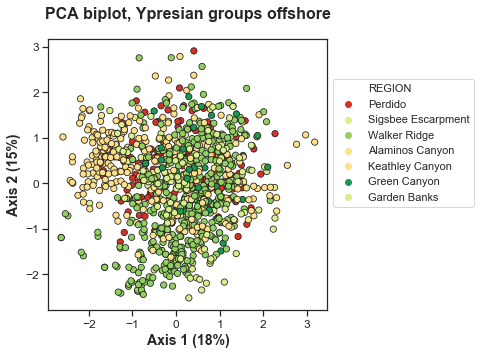

In [29]:
##Axis 1 vs. 2
sns.set(style="ticks", font = 'arial')

plt.subplots(figsize=(5,5))
# ax = draw_vectors(pca_df1, pca.components_, groups.columns.values)
ax = sns.scatterplot(x='PCA1', y='PCA2', hue='REGION', data=ypres_off, 
                     alpha=1, s=40,palette=areas, edgecolor='k')
ax.set_title('PCA biplot, Ypresian groups offshore', fontsize=16, weight='bold', y=1.05)
ax.set_ylabel('Axis 2 (15%)', fontsize=14, weight='bold')
ax.set_xlabel('Axis 1 (18%)', fontsize=14, weight='bold')
ax.tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.85),loc=2, borderaxespad=0.) #Plot legend outside area

# plt.savefig('PCA_ypresian.eps',dpi=300,bbox_inches='tight', transparent=True)
plt.show()

In [67]:
## Split into East and West
east = ['LA', 'AL', 'MS']

## Add a column condition based on a list 
ypres_on['SOURCE'] = np.where(ypres_on.REGION.isin(east),'East','West') #First val (x) is if true, 'y' if false

east_source = ypres_on.loc[(ypres_on.SOURCE == 'East')]
west_source = ypres_on.loc[(ypres_on.SOURCE == 'West')]

In [68]:
west_source.head()

,SITE,P_REGION,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Spinaepollis spinosus,Tetracolporates Grp.,Thomsonipollis magnificus,Triatriopollenites Grp.,Ulmipollenites spp.,Normapolles (Paleocene types),PCA1,PCA2,PCA3,SOURCE
996,HAYNES,ONSHORE,26.96738,-99.1153,Early_Eocene,Ypresian,Wilcox,PPg8,0,7800.0,...,0.0,0.0,0.228748,0.274921,0.152499,0.076249,-1.155455,-0.099403,-0.579601,West
997,HAYNES,ONSHORE,26.96738,-99.1153,Early_Eocene,Ypresian,Wilcox,PPg8,0,7830.0,...,0.0,0.0,0.262962,0.309426,0.126323,0.072932,-1.058616,0.337343,-0.811146,West
998,HAYNES,ONSHORE,26.96738,-99.1153,Early_Eocene,Ypresian,Wilcox,PPg8,0,7860.0,...,0.0,0.0,0.215666,0.304997,0.132068,0.076249,-0.903857,-0.156180,-0.655735,West
999,HAYNES,ONSHORE,26.96738,-99.1153,Early_Eocene,Ypresian,Wilcox,PPg8,0,7890.0,...,0.0,0.0,0.175142,0.303355,0.135665,0.078326,-1.110357,-0.807123,-0.542606,West
1000,HAYNES,ONSHORE,26.96738,-99.1153,Early_Eocene,Ypresian,Wilcox,PPg8,0,7920.0,...,0.0,0.0,0.235702,0.278887,0.149071,0.000000,-1.309853,-0.180355,-0.811699,West


In [24]:
groups.columns.values

array(['Freshwater algae', 'Alnipollenites verus',
       'Annona foveoreticulata', 'Baculatisporites/Osmunda Grp.',
       'Bagelopollis verrucatus', 'Bisaccates', 'Bombacacidites spp.',
       'Brosipollis spp.', 'Caprifoliipites viridifluminis',
       'Caryapollenites spp.', 'Celtispollenites spp.',
       'Chenopodipollenites Grp.', 'Cicatricosisporites Grp.',
       'Deltoidospora spp.', 'Ephedra spp.',
       'Favitricolporites baculoferus', 'Holkopollenites spp.',
       'Intratriporopollenites instructus', 'Ilexpollenites Grp.',
       'Inaperturopollenites spp.',
       'Intratriporopollenites cf. instructus',
       'Kyandopollenites anneratus', 'Labrapollis globosus',
       'Laevigatosporites spp.', 'Lanagiopollis (Paleocene types)',
       'Lanagiopollis (Eocene types)', 'Milfordia spp.', 'Momipites spp.',
       'Palms Grp.', 'Pistillipollenites mcgregorii',
       'Platycaryapollenites spp.', 'Polypodium type',
       'Proxapertites magnus', 'Retistephanocolporites',
  

### Heatmap

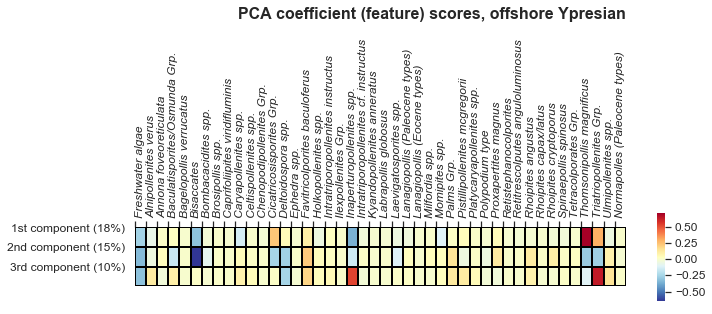

In [28]:
sns.set(font = 'arial')
plt.subplots(figsize=(11,1))
ax=plt.subplot(111)
sns.heatmap(pca.components_[:3], cmap='RdYlBu_r', linewidth=1,linecolor='black',
           cbar_kws={'label': '', 'shrink': 1.5, 'aspect':10})
plt.tick_params(labelsize=12)
plt.suptitle('PCA coefficient (feature) scores, offshore Ypresian', weight='bold', fontsize=16, y=4, **a_font)
plt.subplots_adjust(top=0.94)
ax.xaxis.set_ticks_position('top')
plt.xticks(range(len(groups.columns)),groups.columns, rotation=90, ha='left', **a_font, **itals, fontsize=12)
plt.yticks([0, 1, 2], ['1st component (18%)', '2nd component (15%)', '3rd component (10%)'], 
           **a_font, fontsize=12, rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

plt.savefig('PCA_feature_scores_offshore_Ypresian.jpeg',dpi=300,bbox_inches='tight', transparent=True)
# plt.show()

In [26]:
new_df.columns = ['Component score', 'Group']
new_df.head()

,Component score,Group
0,2.406168,Thomsonipollis magnificus
1,2.105293,Bisaccates
2,1.239973,Freshwater algae
3,1.211791,Triatriopollenites Grp.
4,1.204369,Inaperturopollenites spp.


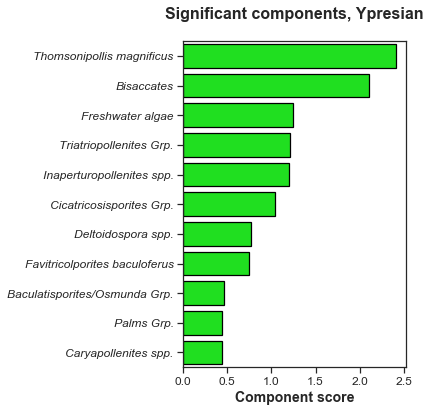

In [27]:
sns.set(style="ticks", font='Arial')

fig, ax = plt.subplots(figsize=(4,6))
ax = sns.barplot(y=new_df['Group'], x=new_df['Component score'],
                 alpha=1,color='#00ff00', linewidth=1, edgecolor='k')
plt.setp(ax.patches, linewidth=1.25, edgecolor='black')
ax.set_title('Significant components, Ypresian', fontsize=16, weight='bold',y=1.05, **a_font)
ax.set_xlabel('Component score', fontsize=14, weight='bold', **a_font)
ax.set_ylabel('')
ax.tick_params(labelsize=12)
ax.set_yticklabels(ax.get_yticklabels(),**a_font, **itals)

plt.show()
# plt.savefig('Important_components_Ypresian.eps',dpi=300,bbox_inches='tight', transparent=True)


In [88]:
len(ypres_on.columns[24:-4])
len(sel_than.columns[21:-3])

39